In [3]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
#from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import matplotlib.ticker as ticker

In [4]:
cal_file1 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam1pixel.h5'
cal_file2 = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Calibration\\8.1.2022\\pixel_registration\\cam2pixel.h5'

In [5]:
t_hor = 5010;
lambda_min = 7;
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [6]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [7]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [8]:
calibration_path =  'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Water_Meas\\7.12.2023\\'

In [9]:
from astropy.timeseries import LombScargle
wavenums = np.divide(1,np.multiply(lambda_c,1e-4))

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    carrier = file['/polarization/carrier'][()]
    W = file['/polarization/W'][()]
    W_ang = file['/polarization/W_ang'][()]
    phase = file['/polarization/phase'][()]
    wavnums = file['/polarization/wavenums'][()]
    aolp_cal =  file['/polarization/aolp'][()]
    dolp_cal =  file['/polarization/dolp'][()]
    dolp_error =  file['/polarization/dolp'][()]
    t_unpol =  file['/transmission/t_unpol'][()]
    t_pol = file['/transmission/t_pol'][()]

In [10]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return([I1,I2])


def MOD(a,band,R1,R2,E1,E2):
#calculate modulation function for calibration data
    i = band

    start = pixel1[i]
    stop  = pixel2[i]
    I1 = R1[a,start:stop]/t_unpol[start:stop]
    I2 = R2[a,start:stop]
    
    I1, I2 = transmission_correction(I1,I2,15)
    
    e1 = E1[a,start:stop]
    e2 = E2[a,start:stop]
    

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1+e2)/(I1+I2)
                            
    return([mod_a,mod_e])

In [11]:
def MOD_total(a,R1,R2,E1,E2):
#calculate modulation function for calibration data
    
    I1 = R1[a]/t_unpol
    I2 = R2[a]
    
    I1, I2 = transmission_correction(I1,I2,15)
    
    e1 = E1[a]
    e2 = E2[a]
    

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1+e2)/(I1+I2)
                            
    return([mod_a,mod_e])

### 6.30.2023

In [ ]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//6.30.2023//Ice//'
angles = [-45,-20,0,20,45]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "Ice-AOI-" + str(angles[i]) + str('deg_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [93]:
t1,t2

(array([28.1, 28.1, 28.1, 28.1, 28.1]), array([27.3, 27.3, 27.3, 27.3, 27.3]))

In [12]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//6.30.2023//Water//'
angles = [-45,-20,0,20,45]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "Water-AOI-" + str(angles[i]) + str('deg-35C_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [13]:
t1,t2

(array([28.3, 28.3, 28.3, 28.3, 28.3]), array([27.6, 27.6, 27.5, 27.5, 27.5]))

In [14]:
for i in range(num):
    std1[i] = np.std(imgs1[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)

In [15]:
xmin1 = 105; xmax1 = 170; #active region
ymin1 = 95; ymax1 = 138;
xmin2 = 105; xmax2 = 165;
ymin2 = 110; ymax2 = 150;

FOV = 5.33
HFOV = FOV/4

In [16]:
im1 = np.zeros([num,3,256,320])
im2 = np.zeros([num,3,256,320])
for t in range(num):
    for i in range(3):
    
    #c1 = (imgs1[t] - np.mean(imgs1[t][200:230,25:50]))    #3C
    #c2 = (imgs2[t] - np.mean(imgs2[t][200:230,25:50]))    
    
        im1[t,i] = (imgs1[t][i] - np.mean(imgs1[t][i][200:230,250:300]))    
        im2[t,i] = (imgs2[t][i] - np.mean(imgs2[t][i][160:170,145:155]))   


In [17]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [18]:
#p1 = pixel_registration(im1[0],cal_file1,waves,0,320)
#p2 = pixel_registration(im2[0],cal_file2,waves,0,320)
#plt.plot(np.sum(p1,axis = 1))
#plt.show()
#plt.plot(np.sum(p2,axis = 1))
#plt.show()
#y2 = np.argmax(np.sum(p2,axis = 1))
#y1 = np.argmax(np.sum(p1,axis = 1))
y2 = 129
y1 = 118

In [19]:
responses = np.zeros([len(angles),3,len(waves)])
responses1 = np.zeros([len(angles),3,len(waves)])
responses2 = np.zeros([len(angles),3,len(waves)])
responses_err = np.zeros([len(angles),3,len(waves)])
responses_err1 = np.zeros([len(angles),3,len(waves)])
responses_err2 = np.zeros([len(angles),3,len(waves)])

for a in range(len(angles)):
    for i in range(3):
        p2 = pixel_registration(im2[a][i],cal_file2,waves,ymin2,ymax2)
        p1 = pixel_registration(im1[a][i],cal_file1,waves,ymin1,ymax1)
        s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
        s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

        err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
        responses[a,i]= (p1[y1-ymin1]+p2[y2-ymin2])
        responses_err[a,i]= err

        responses1[a,i]= p1[y1-ymin1]
        responses_err1[a,i]= s1[y1-ymin1]
        responses2[a,i]= p2[y2-ymin2]
        responses_err2[a,i]= s2[y2-ymin2]

In [184]:
R1_ice = responses1
R2_ice = responses2
E1_ice = responses_err1
E2_ice = responses_err2

In [20]:
R1_w = responses1
R2_w = responses2
E1_w = responses_err1
E2_w = responses_err2

In [21]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c)) #cm
wavnums=list(map(lambda l :1/(l*1.0e-4),waves)) #cm
ret=list(map(lambda l :(retardance(l))*1.0e-4,lambda_c)) #cm

45
9.647058823529413
expected retardance 0.00904911656116212
prob = 0.10791699135672084
best freq = 0.00904911656116212
dolp = 0.1193428142003256
aolp = 0.3400624262946109


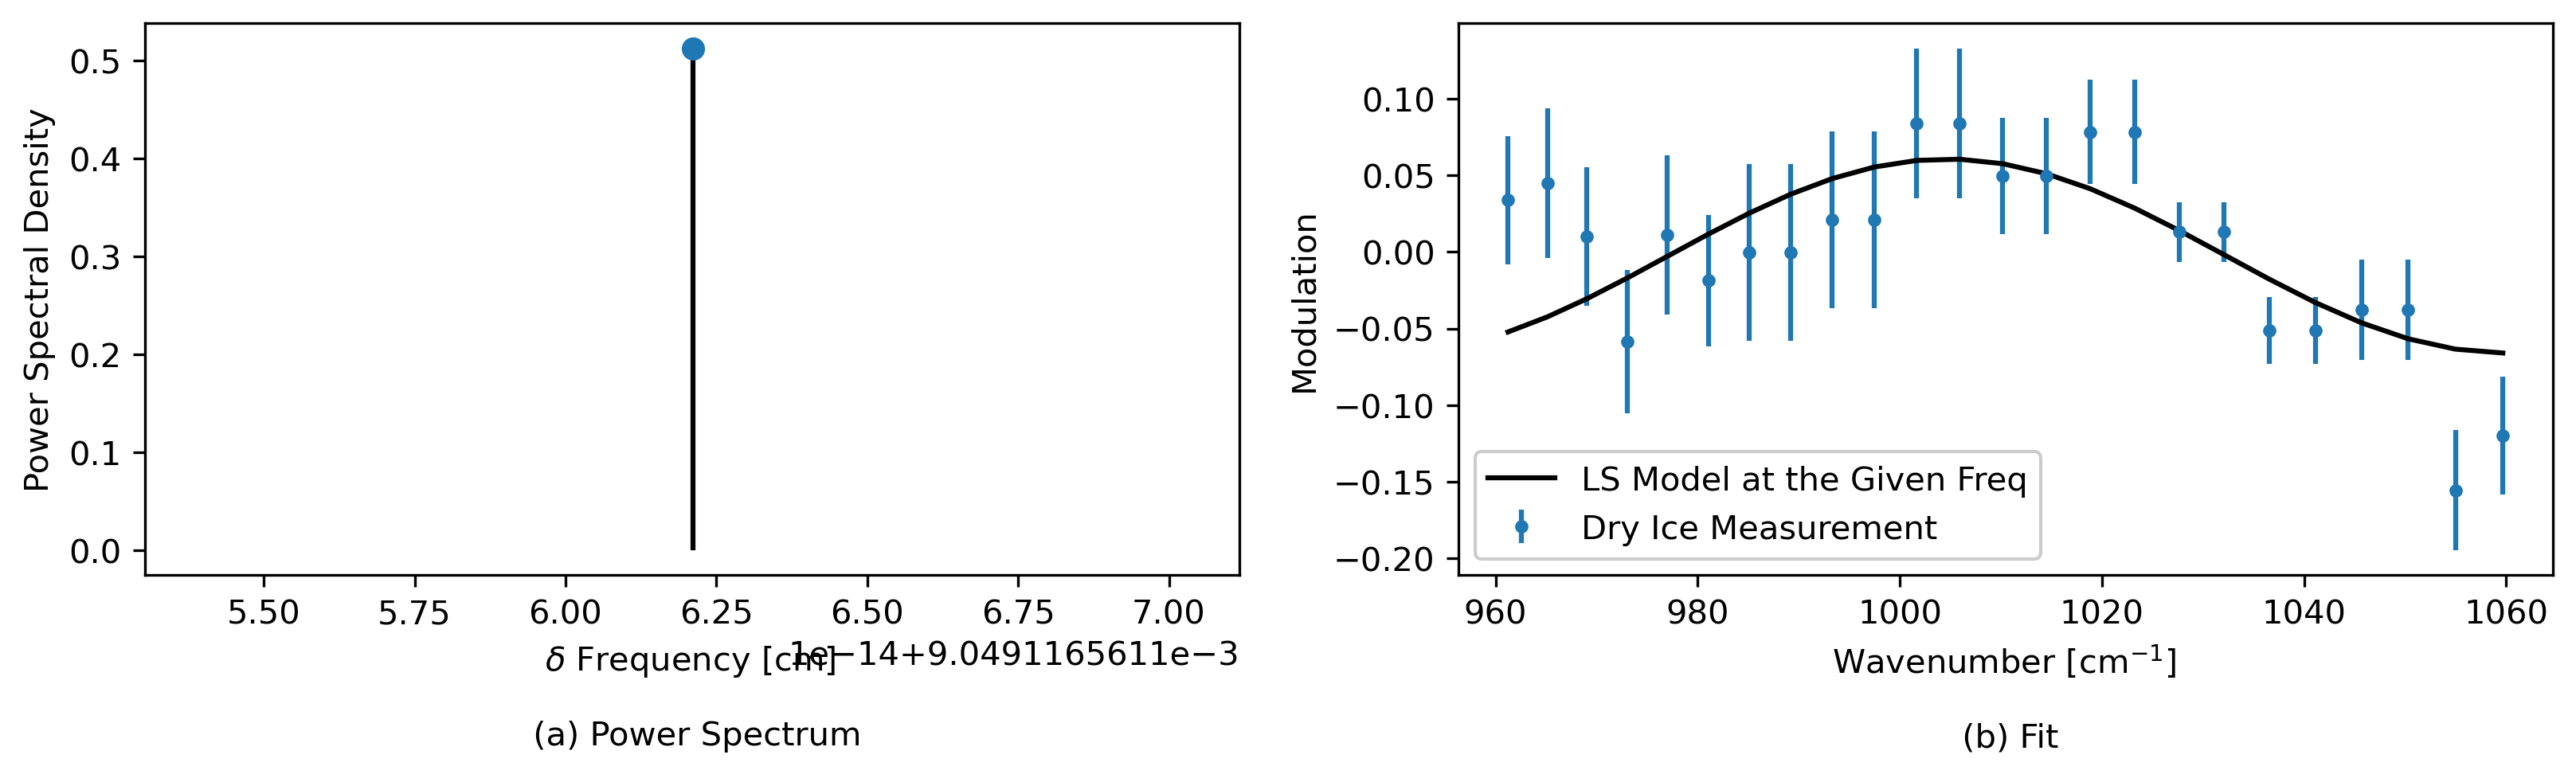

In [22]:


a = 4
j = 56
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]
print('expected retardance ' + str(freq))


x = wav[start:stop]
[y,dy] = MOD(a,j,R1_w[:,1],R2_w[:,1],E1_w[:,1],E2_w[:,1])



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5])

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))

[offset,q,u] = ls.model_parameters(best_frequency)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp_corr))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [23]:
def LombModel(a,j,W,R1,R2,E1,E2):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]

    x = wavnums[start:stop]
    [y,dy] = MOD(a,j,R1,R2,E1,E2)

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    [offset,q,u] = ls.model_parameters(freq)
    U = u
    Q = q
    dolp = (((U)**2 +(Q)**2)**0.5)
    aolp = 0.5*np.arctan2(U,Q)
    aolp_corr = aolp - phase[j]
    idx = find_nearest(W_ang, aolp_corr)
    eff = W[j,idx]
    dolp_corr = dolp/eff
    if dolp > 1:
        [prob,U,Q] =[np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp_corr,Q,U,prob,offset])

In [24]:
lambda_c[90],lambda1[90],lambda2[90]

(11.07563025210084, 10.384687286977336, 11.766573217224344)

In [25]:
#aolp_ice = np.zeros([num,3,90])
#dolp_ice = np.zeros([num,3,90])
#prob_ice = np.zeros([num,3,90])
#for a in range(len(angles)):
 #   for i in range(3):
  #      for j in range(6,90):
   #         out = LombModel(a,j,W,R1_ice[:,i],R2_ice[:,i],E1_ice[:,i],E2_ice[:,i])
    #        dolp_ice[a,i,j] = out[0]
     #       prob_ice[a,i,j] = out[4]
      #      if out[1] < 0:
       #         aolp_ice[a,i,j] = out[1] + np.pi
        #    else:
         #       aolp_ice[a,i,j] = out[1]

aolp_w = np.zeros([num,3,90])
dolp_w = np.zeros([num,3,90])
prob_w = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_w[:,i],R2_w[:,i],E1_w[:,i],E2_w[:,i])
            dolp_w[a,i,j] = out[0]
            prob_w[a,i,j] = out[4]
            if out[1] < 0:
                aolp_w[a,i,j] = out[1] + np.pi
            else:
                aolp_w[a,i,j] = out[1]

In [26]:
#dolp_ice_std = np.zeros([num])
#aolp_ice_std = np.zeros([num])
#for i in range(num):
 #   dolp_ice_std = np.nanstd(dolp_ice,axis =1)
  #  aolp_ice_std = np.nanstd(aolp_ice,axis =1)


dolp_w_std = np.zeros([num])
aolp_w_std = np.zeros([num])
for i in range(num):
    dolp_w_std = np.nanstd(dolp_w,axis =1)
    aolp_w_std = np.nanstd(aolp_w,axis =1)

In [65]:
i = 49
dolp_ice[:,0,i], dolp_w[:,0,i]

(array([0.16764869, 0.13661879, 0.21275778, 0.09293223, 0.0974343 ]),
 array([0.09327743, 0.09423177, 0.09994179, 0.08233295, 0.0671823 ]))

In [66]:
dolp_ice_std[:,34] * 100

array([8.3907229 , 3.55094073, 3.73345324, 8.23775038, 3.18906074])

In [67]:
plt.style.use('seaborn-whitegrid')


Text(0, 0.5, 'DoLP [%]')

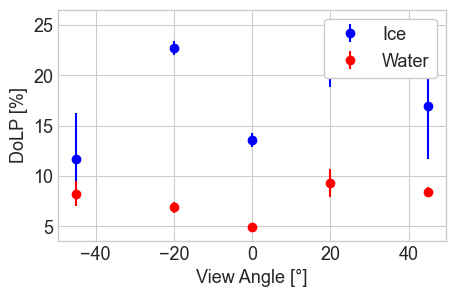

In [68]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

#plt.errorbar(angles,dolp_ice[:,0,34]*100,yerr=dolp_ice_std[:,34]*100,fmt='o',color='b',label='8.7um')
plt.errorbar(angles,dolp_ice[:,0,70]*100,yerr=dolp_ice_std[:,70]*100,fmt='o',color='b',label='Ice')
#plt.errorbar(angles,dolp_w[:,0,34]*100,yerr=dolp_w_std[:,34]*100,fmt='x',color='b')
plt.errorbar(angles,dolp_w[:,2,70]*100,yerr=dolp_w_std[:,70]*100,fmt='o',color='r',label= 'Water')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

In [69]:
yerr1 = np.sqrt((dolp_w_std[:,70]*100)**2 + (dolp_w_std[:,70]*100)**2)

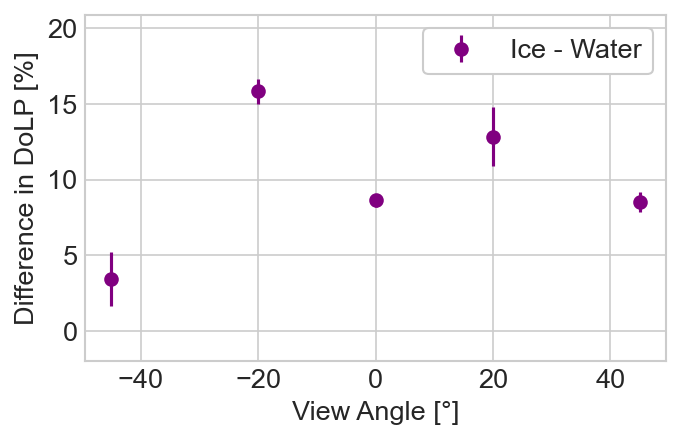

In [70]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,dolp_ice[:,0,70]*100-dolp_w[:,2,70]*100,yerr=yerr1,fmt='o',color='purple',label='Ice - Water')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Difference in DoLP [%]')
plt.gcf().set_dpi(150)
plt.ylim(-2,20.9)
plt.rcParams.update({'font.size':13})

In [71]:
angles[2]

0

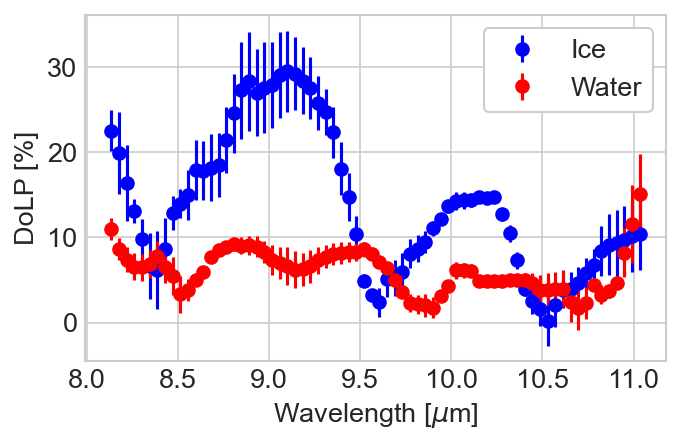

In [72]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 2
plt.errorbar(lambda_c[20:90],dolp_ice[i,2,20:]*100,yerr=dolp_ice_std[i,20:]*100,fmt='o',color='blue',label='Ice')
plt.errorbar(lambda_c[20:90],dolp_w[i,2,20:]*100,yerr=dolp_w_std[i,20:]*100,fmt='o',color='red',label='Water')
plt.ylabel('DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

NameError: name 'dolp1' is not defined

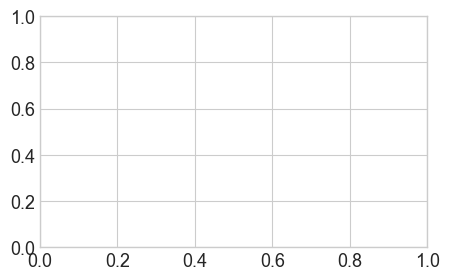

In [73]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 3
plt.errorbar(lambda_c[50:90],dolp1,yerr=dolperror1,fmt='.',color='blue',label='Ice 1.5$^{\circ}C$')
plt.errorbar(lambda_c[50:90],dolp_w[i,2,50:]*100,yerr=dolp_w_std[i,50:]*100,fmt='.',color='red',label='Water 34.9$^{\circ}C$')

plt.errorbar(lambda_c[50:90],dolpsecond,yerr=dolperror,fmt='.',color='pink',label='Melting Ice 1.5$^{\circ}C$')

plt.ylabel('DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
#legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
#legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

NameError: name 'dolp1' is not defined

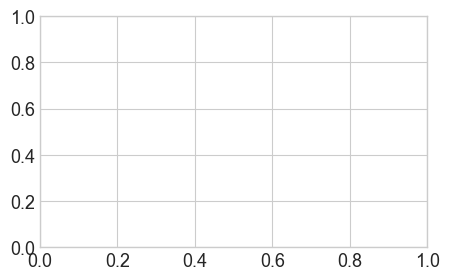

In [74]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 4
plt.errorbar(lambda_c[50:90],dolp1,yerr=dolperror1,fmt='o',color='blue',label='Ice 1.5$^{\circ}C$')
plt.errorbar(lambda_c[50:90],dolp_w[i,2,50:]*100,yerr=dolp_w_std[i,50:]*100,fmt='o',color='red',label='Water 34.9$^{\circ}C$')

plt.errorbar(lambda_c[50:90],dolpsecond,yerr=dolperror,fmt='o',color='pink',label='Melting Ice 1.5$^{\circ}C$')

plt.ylabel('DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
#legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
#legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [75]:
yerr2 = np.sqrt((dolp_ice_std[i,20:]*100)**2 + (dolp_w_std[i,20:]*100)**2)

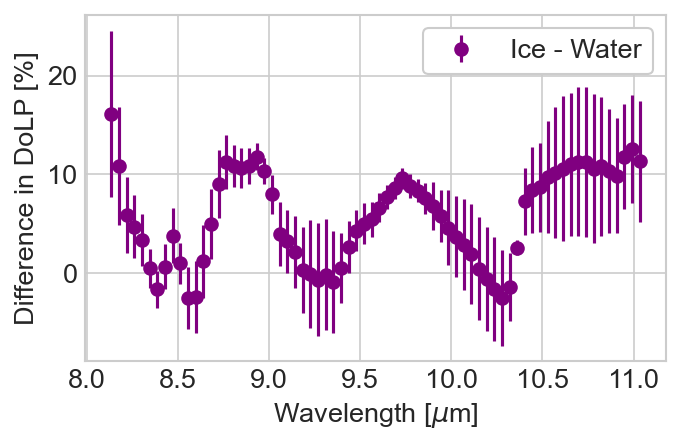

In [76]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 4
plt.errorbar(lambda_c[20:90],dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100,yerr=yerr2,fmt='o',color='purple',label='Ice - Water')
plt.ylabel('Difference in DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [418]:
blah = dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100

In [419]:
lambda_c[20:90][63]

10.781512605042018

In [420]:
blah[63]

10.591889052505087

In [421]:
yerr1 = np.sqrt( dolp_ice_std[i,20:]*100 )**2 + (dolp_w_std[i,20:]*100)**2

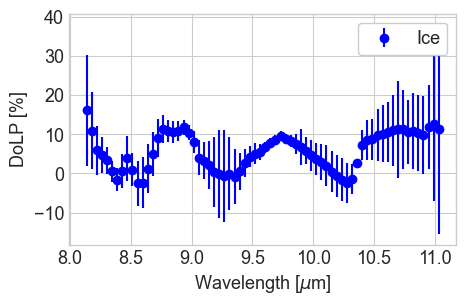

In [422]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 4
plt.errorbar(lambda_c[20:90],dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100,yerr=yerr1,fmt='o',color='blue',label='Ice')
plt.ylabel('DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')

In [423]:
np.rad2deg(aolp_w_std[:,70])


array([ 3.81539507,  5.68994445, 12.81031632,  9.76496667,  4.30245594])

Text(0, 0.5, 'AoLP [°]')

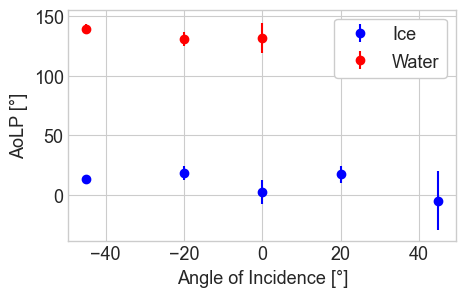

In [424]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,np.rad2deg(np.mean(aolp_ice[:,:,70],axis=1)),yerr=np.rad2deg(aolp_ice_std[:,70]),fmt='o',color='b',label='Ice')

plt.errorbar(angles,np.rad2deg(np.mean(aolp_w[:,:,70],axis=1)),yerr=np.rad2deg(aolp_w_std[:,70]),fmt='o',color='r',label= 'Water')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('AoLP [\N{DEGREE SIGN}]')

In [425]:
error_prop = np.sqrt(((np.rad2deg(aolp_w_std[:,70]))**2+(np.rad2deg(aolp_ice_std[:,70]))**2))

In [426]:
exp1 = np.rad2deg(np.mean(aolp_w[:,:,70],axis=1))-np.rad2deg(np.mean(aolp_ice[:,:,70],axis=1))

In [427]:
error_prop2 = np.sqrt(((np.rad2deg(aolp_w_std[:,70]))**2+(np.rad2deg(aolp_ice_std[:,70]))**2))

In [428]:
(np.rad2deg(aolp_w_std[:,70]))

array([ 3.81539507,  5.68994445, 12.81031632,  9.76496667,  4.30245594])

In [429]:
exp2 = np.rad2deg(aolp_w[:,2,70])-np.rad2deg(aolp_ice[:,0,70])

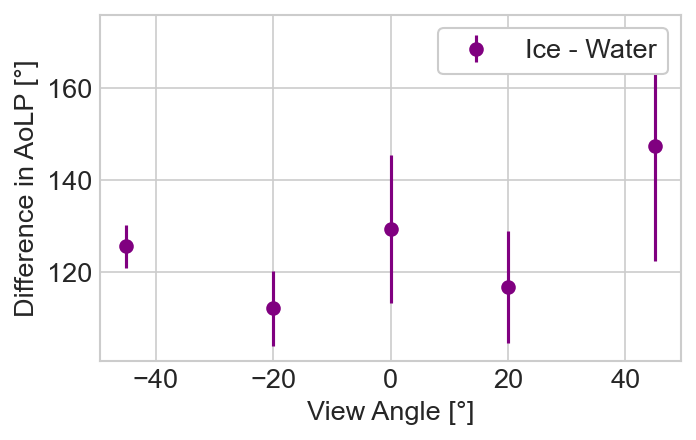

In [430]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,exp1,yerr=error_prop,fmt='o',color='purple',label="Ice - Water")
#plt.errorbar(angles,exp2,yerr=error_prop2,fmt='o',color='green',label="Second")

legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Difference in AoLP [\N{DEGREE SIGN}]')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

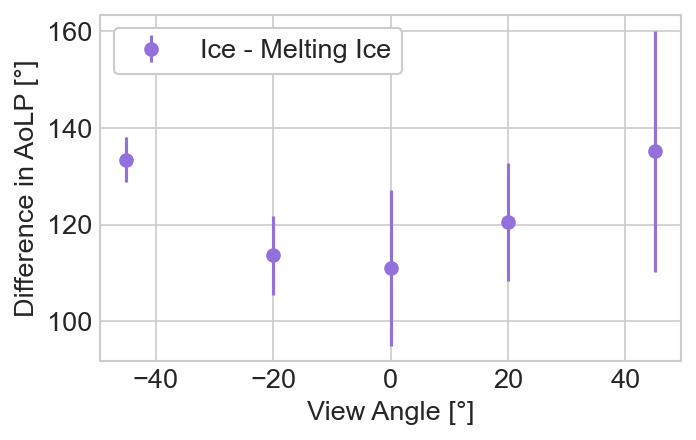

In [431]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,exp2,yerr=error_prop2,fmt='o',color='mediumpurple',label="Ice - Melting Ice")
#plt.errorbar(angles,exp2,yerr=error_prop2,fmt='o',color='green',label="Second")

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Difference in AoLP [\N{DEGREE SIGN}]')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [432]:
np.rad2deg(aolp_w[:,0,34])

array([114.61562135, 117.00640275, 122.65269891, 128.11190915,
       128.41978071])

In [433]:
np.rad2deg(np.nanmean(aolp_ice[:,0,87]))

-2.2686529842526593

In [32]:
calibration_path = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Water_Meas\\6.30.2023\\'

In [33]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
   # nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]
    #contextfit = file['/radiometric/contextfit'][()]

In [34]:
def get_BT(j,i,f,R1,R2,n,E1,E2):
    bt = []
    Et = []
    for a in range(i,f):
        start = pixel1[j]
        stop  = pixel2[j]
       # corr = t_pol[find_nearest(aolp[j,a],cal_angles),j]*(1-dolp[j,a])
        response = np.sum(R1[a,n,start:stop]+R2[a,n,start:stop])
        response_err = np.sum(E1[a,start:stop]+E2[a,start:stop])
        temp = func(response,var[j,0],var[j,1])
        error = func(response+response_err/2,var[j,0],var[j,1])-func(response-response_err/2,var[j,0],var[j,1])
        if temp > 400:
            bt.append(np.nan)
            Et.append(np.nan)
        else:
            bt.append(temp)
            Et.append(error)
    return([bt,Et])

In [35]:
ii = 0
ff = num


#bt1_ice = get_BT(34,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[0]
#bt2_ice = get_BT(68,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[0]
#bt3_ice = get_BT(56,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[0]
#et1_ice = get_BT(34,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[1]
#et2_ice = get_BT(68,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[1]
#et3_ice = get_BT(56,ii,ff,R1_ice,R2_ice,0,E1_ice,E2_ice)[1]


bt1_w = get_BT(34,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[0]
bt2_w = get_BT(68,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[0]
bt3_w = get_BT(56,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[0]
et1_w = get_BT(34,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[1]
et2_w = get_BT(68,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[1]
et3_w = get_BT(56,ii,ff,R1_w,R2_w,0,E1_w,E2_w)[1]

In [36]:
ii = 0
ff = num

#bt1_ice = np.zeros([num,3,90])
bt1_w = np.zeros([num,3,90])
for j in range(90):
    for n in range(3):
        
      #  bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n,E1_ice,E2_ice)[0]
       # bt2_ice[:,n] = get_BT(70,ii,ff,R1_ice,R2_ice,n)[0]
       # bt3_ice[:,n] = get_BT(56,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_w[:,n,j] = get_BT(j,ii,ff,R1_w,R2_w,n,E1_w,E2_w)[0]
       # bt2_w[:,n] = get_BT(70,ii,ff,R1_w,R2_w,n)[0]
        #bt3_w[:,n] = get_BT(56,ii,ff,R1_w,R2_w,n)[0]


#et1_ice = np.nanstd(bt1_ice,axis=1)
et1_w = np.nanstd(bt1_w,axis=1)

C:\Users\khart\AppData\Local\Continuum\anaconda3\envs\flirpy\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [37]:
np.shape(et1_ice[:])

NameError: name 'et1_ice' is not defined

NameError: name 'bt1_ice' is not defined

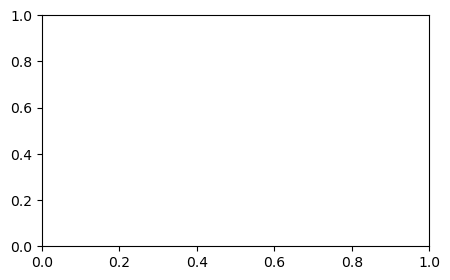

In [38]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.errorbar(angles[:],np.nanmean(bt1_ice[:,0,20:90],axis=1),yerr=np.nanmean(et1_ice[:,20:90],axis=1),fmt='o',color='b',label='Ice')

plt.errorbar(angles[:],np.nanmean(bt1_w[:,0,20:90],axis=1),yerr=np.nanmean(et1_w[:,20:90],axis=1),fmt='o',color='r',label= 'Water')

#plt.errorbar(angles,np.mean(bt1_ice[:,0,:],axis=1),yerr=dolp_ice_std[:,70]*100,fmt='x',color='r')#,label='Ice')

#plt.errorbar(angles,np.mean(bt1_w[:,0,:],axis=1),yerr=dolp_w_std[:,70]*100,fmt='x',color='b')#,label= 'Water')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Brightness Temperature [K]')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [39]:
np.nanmean(bt1_w[:,0,20:90],axis=1)

array([309.87769019, 306.75445672, 306.14748776, 306.05877615,
       303.01797998])

In [40]:
et1_ice[3,50:]

NameError: name 'et1_ice' is not defined

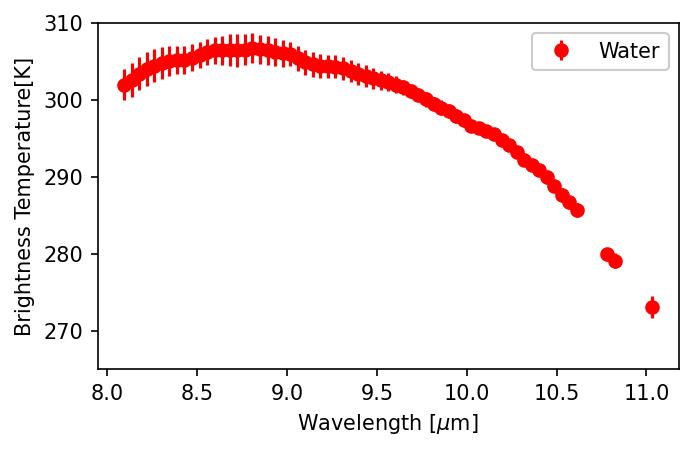

In [41]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 3
plt.gcf().set_dpi(150)

#plt.errorbar(lambda_c[19:90],bt1_ice[i,1,19:],yerr=et1_ice[i,19:],fmt='o',color='b',label='Ice')
plt.errorbar(lambda_c[19:90],bt1_w[i,1,19:],yerr=et1_w[i,19:],fmt='o',color='r',label="Water")
plt.ylabel('Brightness Temperature[K]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('Wavelength [$\mu$m]')
plt.ylim(265,310)
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [42]:
#bt1_ice_1 = bt1_ice[i,1,19:] 
bt1_w_1 = bt1_w[i,1,19:]

### 7.7.2023

In [43]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.7.2023//'
angles = [-45,-20,0,20,45]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "Mixed-1.5C" + str(angles[i]) + str('AOI_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [76]:
t1,t2

(array([26.8, 26.8, 26.8, 26.8, 26.8]), array([26. , 26. , 26. , 25.9, 25.9]))

In [49]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.7.2023//'
angles = [-45,-20,0,20,45]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "Ice-1.5C" + str(angles[i]) + str('AOI_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [50]:
t1,t2

(array([26.6, 26.6, 26.6, 26.6, 26.7]), array([25.8, 25.8, 25.7, 25.8, 25.8]))

In [51]:
for i in range(num):
    std1[i] = np.std(imgs1[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)

In [52]:
im1 = np.zeros([num,3,256,320])
im2 = np.zeros([num,3,256,320])
for t in range(num):
    for i in range(3):
    
    #c1 = (imgs1[t] - np.mean(imgs1[t][200:230,25:50]))    #3C
    #c2 = (imgs2[t] - np.mean(imgs2[t][200:230,25:50]))    
    
        im1[t,i] = (imgs1[t][i] - np.mean(imgs1[t][i][200:230,250:300]))    
        im2[t,i] = (imgs2[t][i] - np.mean(imgs2[t][i][160:170,145:155]))   


In [53]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [54]:
responses = np.zeros([len(angles),3,len(waves)])
responses1 = np.zeros([len(angles),3,len(waves)])
responses2 = np.zeros([len(angles),3,len(waves)])
responses_err = np.zeros([len(angles),3,len(waves)])
responses_err1 = np.zeros([len(angles),3,len(waves)])
responses_err2 = np.zeros([len(angles),3,len(waves)])

for a in range(len(angles)):
    for i in range(3):
        p2 = pixel_registration(im2[a][i],cal_file2,waves,ymin2,ymax2)
        p1 = pixel_registration(im1[a][i],cal_file1,waves,ymin1,ymax1)
        s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
        s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

        err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
        responses[a,i]= (p1[y1-ymin1]+p2[y2-ymin2])
        responses_err[a,i]= err

        responses1[a,i]= p1[y1-ymin1]
        responses_err1[a,i]= s1[y1-ymin1]
        responses2[a,i]= p2[y2-ymin2]
        responses_err2[a,i]= s2[y2-ymin2]

In [55]:
R1_ice = responses1
R2_ice = responses2
E1_ice = responses_err1
E2_ice = responses_err2

In [48]:
R1_m = responses1
R2_m = responses2
E1_m = responses_err1
E2_m = responses_err2

In [56]:
aolp_ice = np.zeros([num,3,90])
dolp_ice = np.zeros([num,3,90])
prob_ice = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_ice[:,i],R2_ice[:,i],E1_ice[:,i],E2_ice[:,i])
            dolp_ice[a,i,j] = out[0]
            prob_ice[a,i,j] = out[4]
            if out[1] < 0:
                aolp_ice[a,i,j] = out[1] #+ np.pi
            else:
                aolp_ice[a,i,j] = out[1]
                
aolp_m = np.zeros([num,3,90])
dolp_m = np.zeros([num,3,90])
prob_m = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_m[:,i],R2_m[:,i],E1_m[:,i],E2_m[:,i])
            dolp_m[a,i,j] = out[0]
            prob_m[a,i,j] = out[4]
            if out[1] < 0:
                aolp_m[a,i,j] = out[1] #+ np.pi
            else:
                aolp_m[a,i,j] = out[1]

In [57]:
dolp_ice_std = np.zeros([num])
aolp_ice_std = np.zeros([num])
for i in range(num):
    dolp_ice_std = np.nanstd(dolp_ice,axis =1)
    aolp_ice_std = np.nanstd(aolp_ice,axis =1)


dolp_m_std = np.zeros([num])
aolp_m_std = np.zeros([num])
for i in range(num):
    dolp_m_std = np.nanstd(dolp_m,axis =1)
    aolp_m_std = np.nanstd(aolp_m,axis =1)

Text(0, 0.5, 'DoLP [%]')

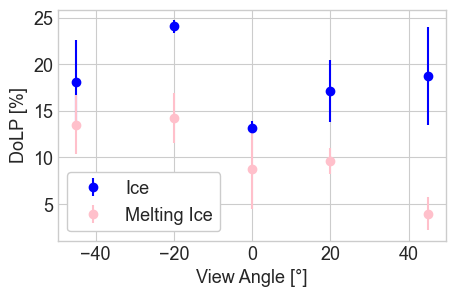

In [77]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

#plt.errorbar(angles,dolp_ice[:,0,34]*100,yerr=dolp_ice_std[:,34]*100,fmt='o',color='b',label='8.7um')
plt.errorbar(angles,dolp_ice[:,1,70]*100,yerr=dolp_ice_std[:,70]*100,fmt='o',color='b',label='Ice')
#plt.errorbar(angles,dolp_w[:,0,34]*100,yerr=dolp_w_std[:,34]*100,fmt='x',color='b')
plt.errorbar(angles,dolp_m[:,2,70]*100,yerr=dolp_m_std[:,70]*100,fmt='o',color='pink',label= 'Melting Ice')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

In [78]:
yerr3 = np.sqrt((dolp_ice_std[:,70]*100)**2 + (dolp_w_std[:,70]*100)**2)

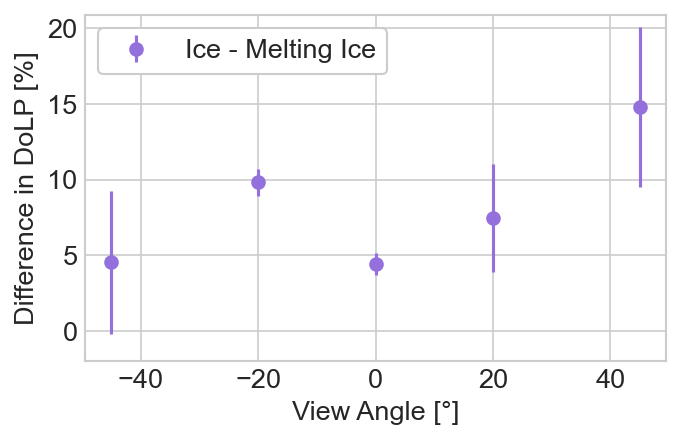

In [79]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,dolp_ice[:,1,70]*100-dolp_m[:,2,70]*100,yerr=yerr3,fmt='o',color='mediumpurple',label='Ice - Melting Ice')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Difference in DoLP [%]')
plt.gcf().set_dpi(150)
plt.ylim(-2,20.9)
plt.rcParams.update({'font.size':13})

Text(0, 0.5, 'DoLP [%]')

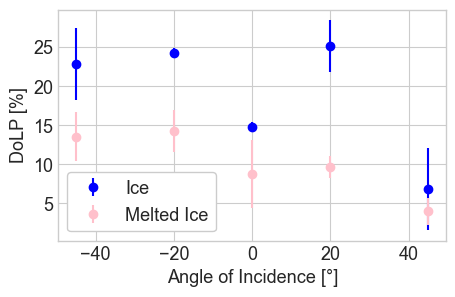

In [80]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

#plt.errorbar(angles,dolp_ice[:,0,34]*100,yerr=dolp_ice_std[:,34]*100,fmt='o',color='b',label='8.7um')
plt.errorbar(angles,dolp_ice[:,2,70]*100,yerr=dolp_ice_std[:,70]*100,fmt='o',color='b',label='Ice')
#plt.errorbar(angles,dolp_w[:,0,34]*100,yerr=dolp_w_std[:,34]*100,fmt='x',color='b')
plt.errorbar(angles,dolp_m[:,2,70]*100,yerr=dolp_m_std[:,70]*100,fmt='o',color='pink',label= 'Melted Ice')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

Text(0, 0.5, 'DoLP [%]')

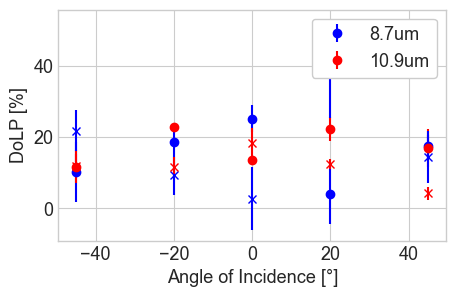

In [81]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,dolp_ice[:,0,34]*100,yerr=dolp_ice_std[:,34]*100,fmt='o',color='b',label='8.7um')
plt.errorbar(angles,dolp_ice[:,0,70]*100,yerr=dolp_ice_std[:,70]*100,fmt='o',color='r',label='10.9um')
#plt.errorbar(angles,dolp_ice[:,0,56]*100,yerr=dolp_ice_std[:,56]*100,fmt='o',color='orange',label='9.6um')
plt.errorbar(angles,dolp_m[:,0,34]*100,yerr=dolp_m_std[:,34]*100,fmt='x',color='b')
plt.errorbar(angles,dolp_m[:,0,70]*100,yerr=dolp_m_std[:,70]*100,fmt='x',color='r')
#plt.errorbar(angles,dolp_w[:,0,56]*100,yerr=dolp_w_std[:,56]*100,fmt='x',color='orange')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

In [82]:
angles[4]

45

Text(0.5, 1.0, '45$^{\\circ}$ View Angle')

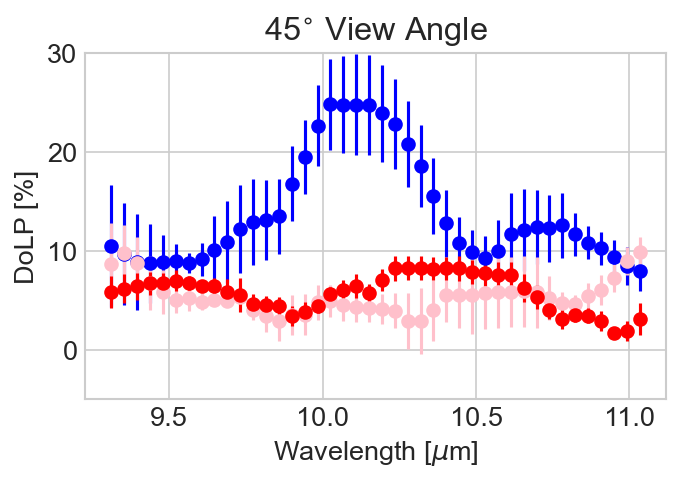

In [133]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 0
plt.errorbar(lambda_c[48:90],dolp_ice[i,2,48:]*100,yerr=dolp_ice_std[i,48:]*100,fmt='o',color='blue',label='Ice')
plt.errorbar(lambda_c[48:90],dolp_m[4,2,48:]*100,yerr=dolp_m_std[4,48:]*100,fmt='o',color='pink',label='Melting Ice')
plt.errorbar(lambda_c[48:90],dolp_w[0,2,48:]*100,yerr=dolp_w_std[0,48:]*100,fmt='o',color='red',label='Water')
plt.gcf().set_dpi(150)

plt.ylabel('DoLP [%]')
plt.ylim(-5,30)
plt.xlabel('Wavelength [$\mu$m]')
plt.title(str(angles[4]) + str('$^{\circ}$ View Angle'))
#legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
#legend.get_frame().set_facecolor('w')

In [123]:
angles[4]

45

In [97]:
dolpsecond = dolp_m[i,2,50:]*100
dolperror = dolp_m_std[i,50:]*100

dolp1 = dolp_ice[i,2,50:]*100
dolperror1 = dolp_ice_std[i,50:]*100

In [98]:
yerr4 =np.sqrt((dolp_ice_std[i,20:]*100)**2 + (dolp_w_std[i,20:]*100)**2)

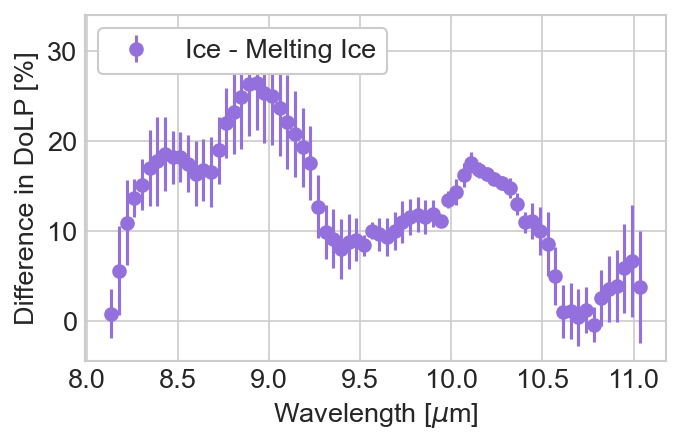

In [99]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 3
plt.errorbar(lambda_c[20:90],dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100,yerr=yerr4,fmt='o',color='mediumpurple',label='Ice - Melting Ice')
plt.ylabel('Difference in DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

In [100]:
dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100

array([ 0.78052352,  5.56765032, 10.95746533, 13.6523011 , 15.17399501,
       17.01122983, 17.76368799, 18.53584691, 18.20267163, 18.28838669,
       17.52034307, 16.38975215, 16.8076141 , 16.56365602, 18.9862471 ,
       22.02914073, 23.2985622 , 24.92279265, 26.41910161, 26.49412371,
       25.34412705, 24.97925953, 23.6628274 , 22.1563126 , 20.77145999,
       19.33958515, 17.57882199, 12.73456077,  9.90496962,  9.14982289,
        8.00160796,  8.84074112,  9.06853606,  8.4303101 , 10.01782618,
        9.63619143,  9.38932426, 10.02392995, 10.99877839, 11.5354241 ,
       11.82713134, 11.56594083, 11.9267559 , 11.09690591, 13.50434493,
       14.35182618, 16.24617494, 17.59726868, 16.84199078, 16.3664768 ,
       15.81161064, 15.34176238, 14.7818805 , 13.01136381, 11.00288189,
       11.12269804, 10.05593672,  8.54981266,  5.02058679,  1.05150705,
        1.14962184,  0.4192328 ,  1.24440469, -0.4331652 ,  2.58794537,
        3.52002926,  3.94196936,  5.8494682 ,  6.66999005,  3.78

In [101]:
yerr4 = np.sqrt((dolp_ice_std[i,20:]*100)**2 + (dolp_w_std[i,20:]*100)**2)

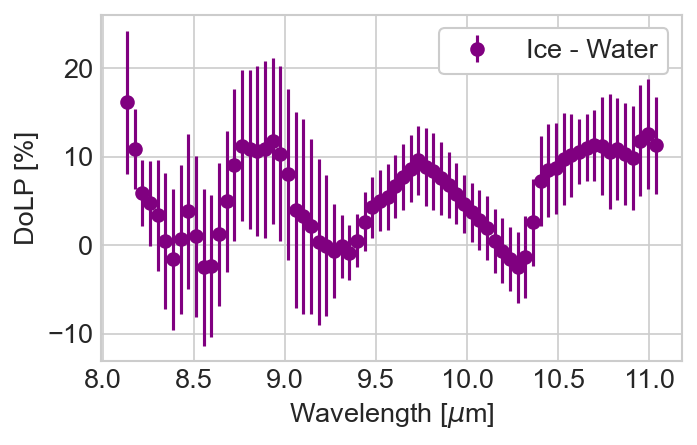

In [102]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 4
plt.errorbar(lambda_c[20:90],dolp_ice[i,2,20:]*100-dolp_w[i,2,20:]*100,yerr=yerr4,fmt='o',color='purple',label='Ice - Water')
plt.ylabel('DoLP [%]')
plt.xlabel('Wavelength [$\mu$m]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

Text(0, 0.5, 'AoLP [°]')

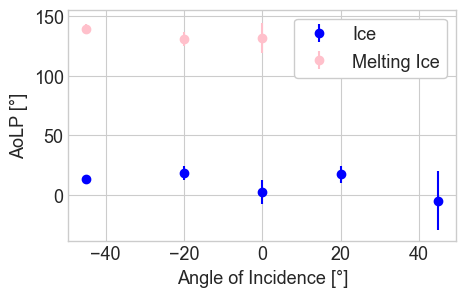

In [103]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,np.rad2deg(np.mean(aolp_ice[:,:,70],axis=1)),yerr=np.rad2deg(aolp_ice_std[:,70]),fmt='o',color='b',label='Ice')

plt.errorbar(angles,np.rad2deg(np.mean(aolp_w[:,:,70],axis=1)),yerr=np.rad2deg(aolp_w_std[:,70]),fmt='o',color='pink',label= 'Melting Ice')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('AoLP [\N{DEGREE SIGN}]')

In [104]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3,90])
bt1_m = np.zeros([num,3,90])
for j in range(90):
    for n in range(3):
        bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n,E1_ice,E2_ice)[0]
       # bt2_ice[:,n] = get_BT(70,ii,ff,R1_ice,R2_ice,n)[0]
       # bt3_ice[:,n] = get_BT(56,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_m[:,n,j] = get_BT(j,ii,ff,R1_m,R2_m,n,E1_m,E2_m)[0]
       # bt2_w[:,n] = get_BT(70,ii,ff,R1_w,R2_w,n)[0]
        #bt3_w[:,n] = get_BT(56,ii,ff,R1_w,R2_w,n)[0]


et1_ice = np.std(bt1_ice,axis=1)
et1_w = np.std(bt1_w,axis=1)

In [105]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3,90])
bt1_w = np.zeros([num,3,90])
for j in range(90):
    for n in range(3):
        bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n,aolp_w,dolp_w)[0]
       # bt2_ice[:,n] = get_BT(70,ii,ff,R1_ice,R2_ice,n)[0]
       # bt3_ice[:,n] = get_BT(56,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_w[:,n,j] = get_BT(j,ii,ff,R1_w,R2_w,n,aolp_ice,dolp_ice)[0]
       # bt2_w[:,n] = get_BT(70,ii,ff,R1_w,R2_w,n)[0]
        #bt3_w[:,n] = get_BT(56,ii,ff,R1_w,R2_w,n)[0]


et1_ice = np.nanstd(bt1_ice,axis=1)
et1_w = np.nanstd(bt1_w,axis=1)

C:\Users\khart\AppData\Local\Continuum\anaconda3\envs\flirpy\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [106]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3,90])
bt1_m= np.zeros([num,3,90])
for j in range(90):
    for n in range(3):
        bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n,E1_ice,E2_ice)[0]
       # bt2_ice[:,n] = get_BT(70,ii,ff,R1_ice,R2_ice,n)[0]
       # bt3_ice[:,n] = get_BT(56,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_m[:,n,j] = get_BT(j,ii,ff,R1_m,R2_m,n,E1_m,E2_w)[0]
       # bt2_w[:,n] = get_BT(70,ii,ff,R1_w,R2_w,n)[0]
        #bt3_w[:,n] = get_BT(56,ii,ff,R1_w,R2_w,n)[0]


et1_ice = np.nanstd(bt1_ice,axis=1)
et1_m = np.nanstd(bt1_m,axis=1)

Text(0, 0.5, 'Brightness Temperature [K]')

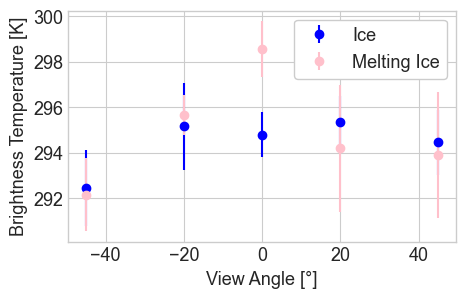

In [107]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,np.nanmean(bt1_ice[:,0,:],axis=1),yerr=np.nanmean(et1_ice,axis=1),fmt='o',color='b',label='Ice')

plt.errorbar(angles,np.nanmean(bt1_m[:,0,:],axis=1),yerr=np.nanmean(et1_m,axis=1),fmt='o',color='pink',label= 'Melting Ice')

#plt.errorbar(angles,np.mean(bt1_ice[:,0,:],axis=1),yerr=dolp_ice_std[:,70]*100,fmt='x',color='r')#,label='Ice')

#plt.errorbar(angles,np.mean(bt1_w[:,0,:],axis=1),yerr=dolp_w_std[:,70]*100,fmt='x',color='b')#,label= 'Water')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
plt.ylabel('Brightness Temperature [K]')

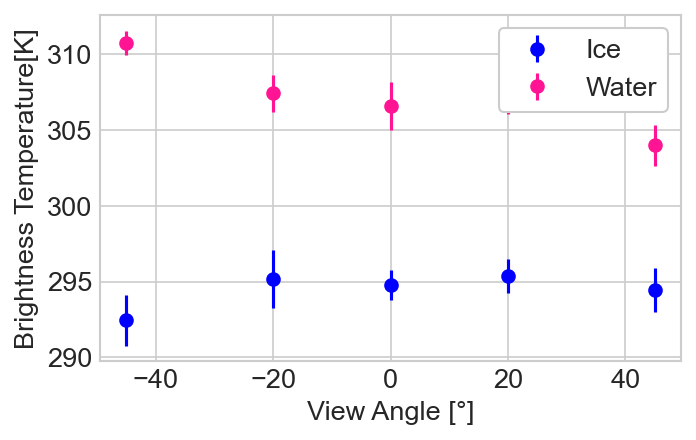

In [108]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.errorbar(angles,np.nanmean(bt1_ice[:,0,:],axis=1),yerr=np.nanmean(et1_ice[:,:],axis=1),fmt='o',color='b',label='Ice')
plt.errorbar(angles,np.nanmean(bt1_w[:,0,:],axis=1),yerr=np.nanmean(et1_w[:,:],axis=1),fmt='o',color='deeppink',label="Water")
plt.ylabel('Brightness Temperature[K]')
plt.xlabel('View Angle [\N{DEGREE SIGN}]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

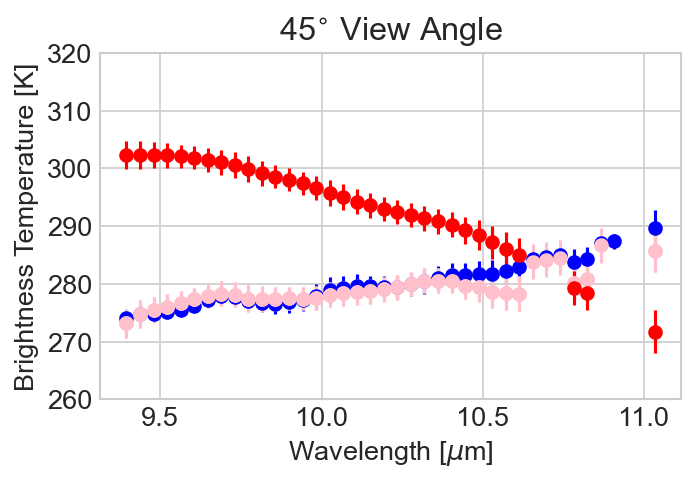

In [120]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
i = 4
plt.errorbar(lambda_c[50:90],bt1_ice[i,0,50:]-5,yerr=et1_ice[3,50:],fmt='o',color='b',label='Ice 1.5C')
plt.errorbar(lambda_c[80],bt1_ice[i,0,80]-111,yerr=et1_ice[i,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[81],bt1_ice[i,0,81]-111,yerr=et1_ice[i,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[82],bt1_ice[i,0,82]-111,yerr=et1_ice[i,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[85],bt1_ice[i,0,85]-110,yerr=et1_ice[i,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[86],bt1_ice[i,0,86]-110,yerr=et1_ice[i,79],fmt='o',color='b')#,label='Ice')

plt.errorbar(lambda_c[50:90],bt1_m[i,0,50:]-5,yerr=et1_m[i,50:],fmt='o',color='pink',label="Melting Ice 1.5C")
plt.errorbar(lambda_c[50:90],bt1_m[i,0,50:]-5,yerr=et1_m[i,50:],fmt='o',color='pink')#,label='Ice')
plt.errorbar(lambda_c[80],bt1_m[i,0,80]-111,yerr=et1_m[i,79],fmt='o',color='pink')#,label='Ice')
plt.errorbar(lambda_c[81],bt1_m[i,0,81]-111,yerr=et1_m[i,79],fmt='o',color='pink')#,label='Ice')
plt.errorbar(lambda_c[82],bt1_m[i,0,82]-111,yerr=et1_m[i,79],fmt='o',color='pink')#,label='Ice')
plt.errorbar(lambda_c[85],bt1_m[i,0,85]-110,yerr=et1_m[i,79],fmt='o',color='pink')#,label='Ice')

plt.errorbar(lambda_c[50:90],bt1_w[i,1,50:],yerr=et1_m[i,50:],fmt='o',color='red',label='Water 34.5C')
plt.title(str(angles[i]) + str('$^{\circ}$ View Angle'))

plt.ylabel('Brightness Temperature [K]')
plt.xlabel('Wavelength [$\mu$m]')
plt.ylim(260,320)
#legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

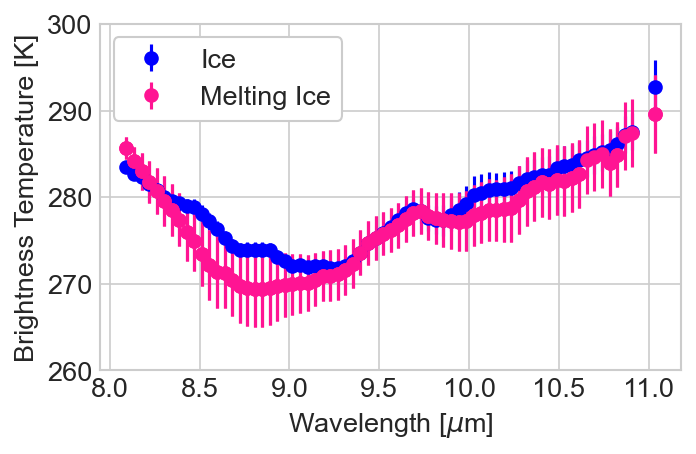

In [252]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.errorbar(lambda_c[19:90],bt1_ice[3,0,19:]-5,yerr=et1_ice[3,19:],fmt='o',color='b',label='Ice')
plt.errorbar(lambda_c[80],bt1_ice[3,0,80]-111,yerr=et1_ice[3,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[81],bt1_ice[3,0,81]-111,yerr=et1_ice[3,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[82],bt1_ice[3,0,82]-111,yerr=et1_ice[3,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[85],bt1_ice[3,0,85]-110,yerr=et1_ice[3,79],fmt='o',color='b')#,label='Ice')
plt.errorbar(lambda_c[86],bt1_ice[3,0,86]-110,yerr=et1_ice[3,79],fmt='o',color='b')#,label='Ice')

plt.errorbar(lambda_c[19:90],bt1_w[3,0,19:]-5,yerr=et1_w[3,19:],fmt='o',color='deeppink',label="Melting Ice")
plt.errorbar(lambda_c[19:90],bt1_w[3,0,19:]-5,yerr=et1_w[3,19:],fmt='o',color='deeppink')#,label='Ice')
plt.errorbar(lambda_c[80],bt1_w[3,0,80]-111,yerr=et1_w[3,79],fmt='o',color='deeppink')#,label='Ice')
plt.errorbar(lambda_c[81],bt1_w[3,0,81]-111,yerr=et1_w[3,79],fmt='o',color='deeppink')#,label='Ice')
plt.errorbar(lambda_c[82],bt1_w[3,0,82]-111,yerr=et1_w[3,79],fmt='o',color='deeppink')#,label='Ice')
plt.errorbar(lambda_c[85],bt1_w[3,0,85]-110,yerr=et1_w[3,79],fmt='o',color='deeppink')#,label='Ice')
plt.errorbar(lambda_c[86],bt1_w[3,0,86]-110,yerr=et1_w[3,79],fmt='o',color='deeppink')#,label='Ice')


plt.ylabel('Brightness Temperature [K]')
plt.xlabel('Wavelength [$\mu$m]')
plt.ylim(260,300)
legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(150)
plt.rcParams.update({'font.size':13})

Text(0, 0.5, 'Brightness Temperature Retrieval')

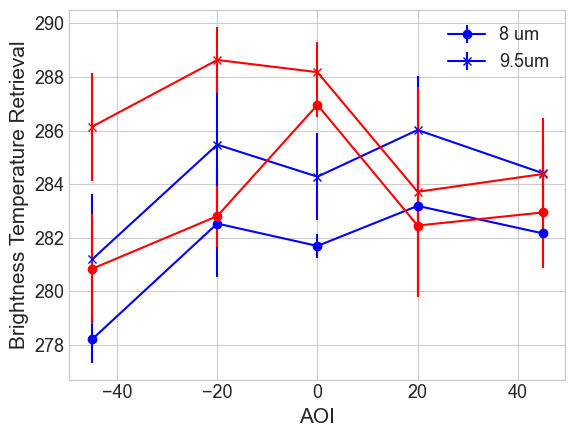

In [250]:
plt.errorbar(angles,bt1_ice[:,0,56],marker = 'o',yerr=et1_ice[:,56],color = 'b',label = '8 um')
plt.errorbar(angles,bt1_ice[:,0,70],marker='x',yerr=et1_ice[:,70],color = 'b',label = '9.5um')
plt.errorbar(angles,bt1_w[:,0,56],marker='o',yerr=et1_w[:,56],color = 'r')#label = '10.1 um')
plt.errorbar(angles,bt1_w[:,0,70],marker='x',yerr=et1_w[:,70],color = 'r')#,label = '10.4um')
plt.legend()
plt.xlabel("AOI",fontsize=15)
plt.ylabel("Brightness Temperature Retrieval",fontsize=15)

In [251]:
bt1_ice[3,:,70], bt1_w[3,:,70]

(array([286.01924197, 281.0969709 , 283.0608916 ]),
 array([283.71245839, 293.25721303, 288.15926565]))

In [4755]:
angles[4]

45

20
10.235294117647058
expected retardance 0.008951293886609384
prob = 0.06770615679173787
best freq = 0.008951293886609384
dolp = 0.5072750436060027
aolp = 1.242992754653673


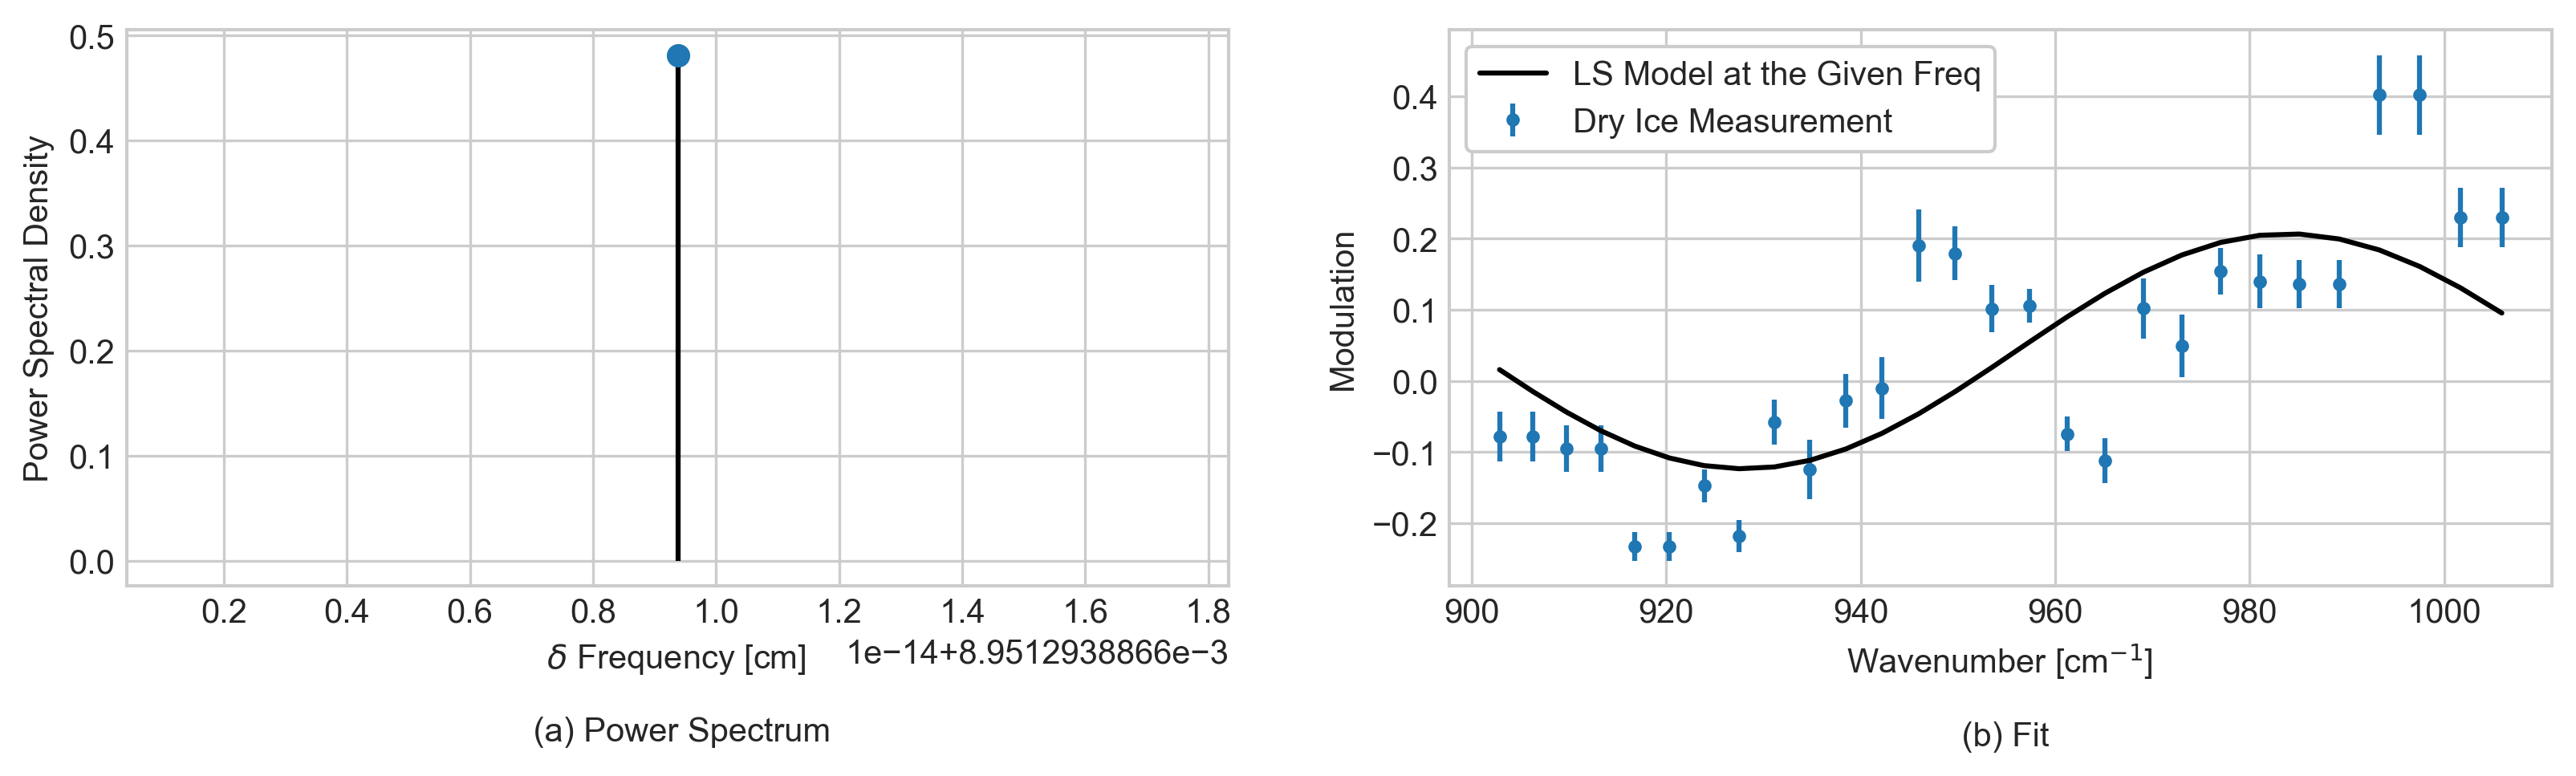

In [4931]:
plt.style.use('seaborn-whitegrid')

a = 3
j = 70
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]
print('expected retardance ' + str(freq))


x = wav[start:stop]
[y,dy] = MOD(a,j,R1_ice[:,1],R2_ice[:,1],E1_ice[:,1],E2_ice[:,1])



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5])

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))

[offset,q,u] = ls.model_parameters(best_frequency)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp_corr))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

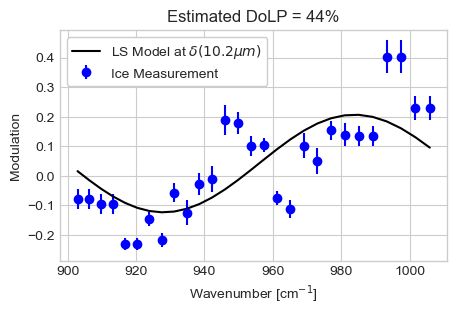

In [4932]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.plot(t_fit,y_fit,'k', label='LS Model at $\delta (10.2\mu m)$')
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Modulation')
plt.errorbar(x,y,yerr = dy,fmt='o',color = 'b', label='Ice Measurement')
plt.title('Estimated DoLP = 44%')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

20
10.235294117647058
expected retardance 0.008951293886609384
prob = 0.8803483503983198
best freq = 0.008951293886609384
dolp = 0.12914823214592924
aolp = 0.39178257064596833


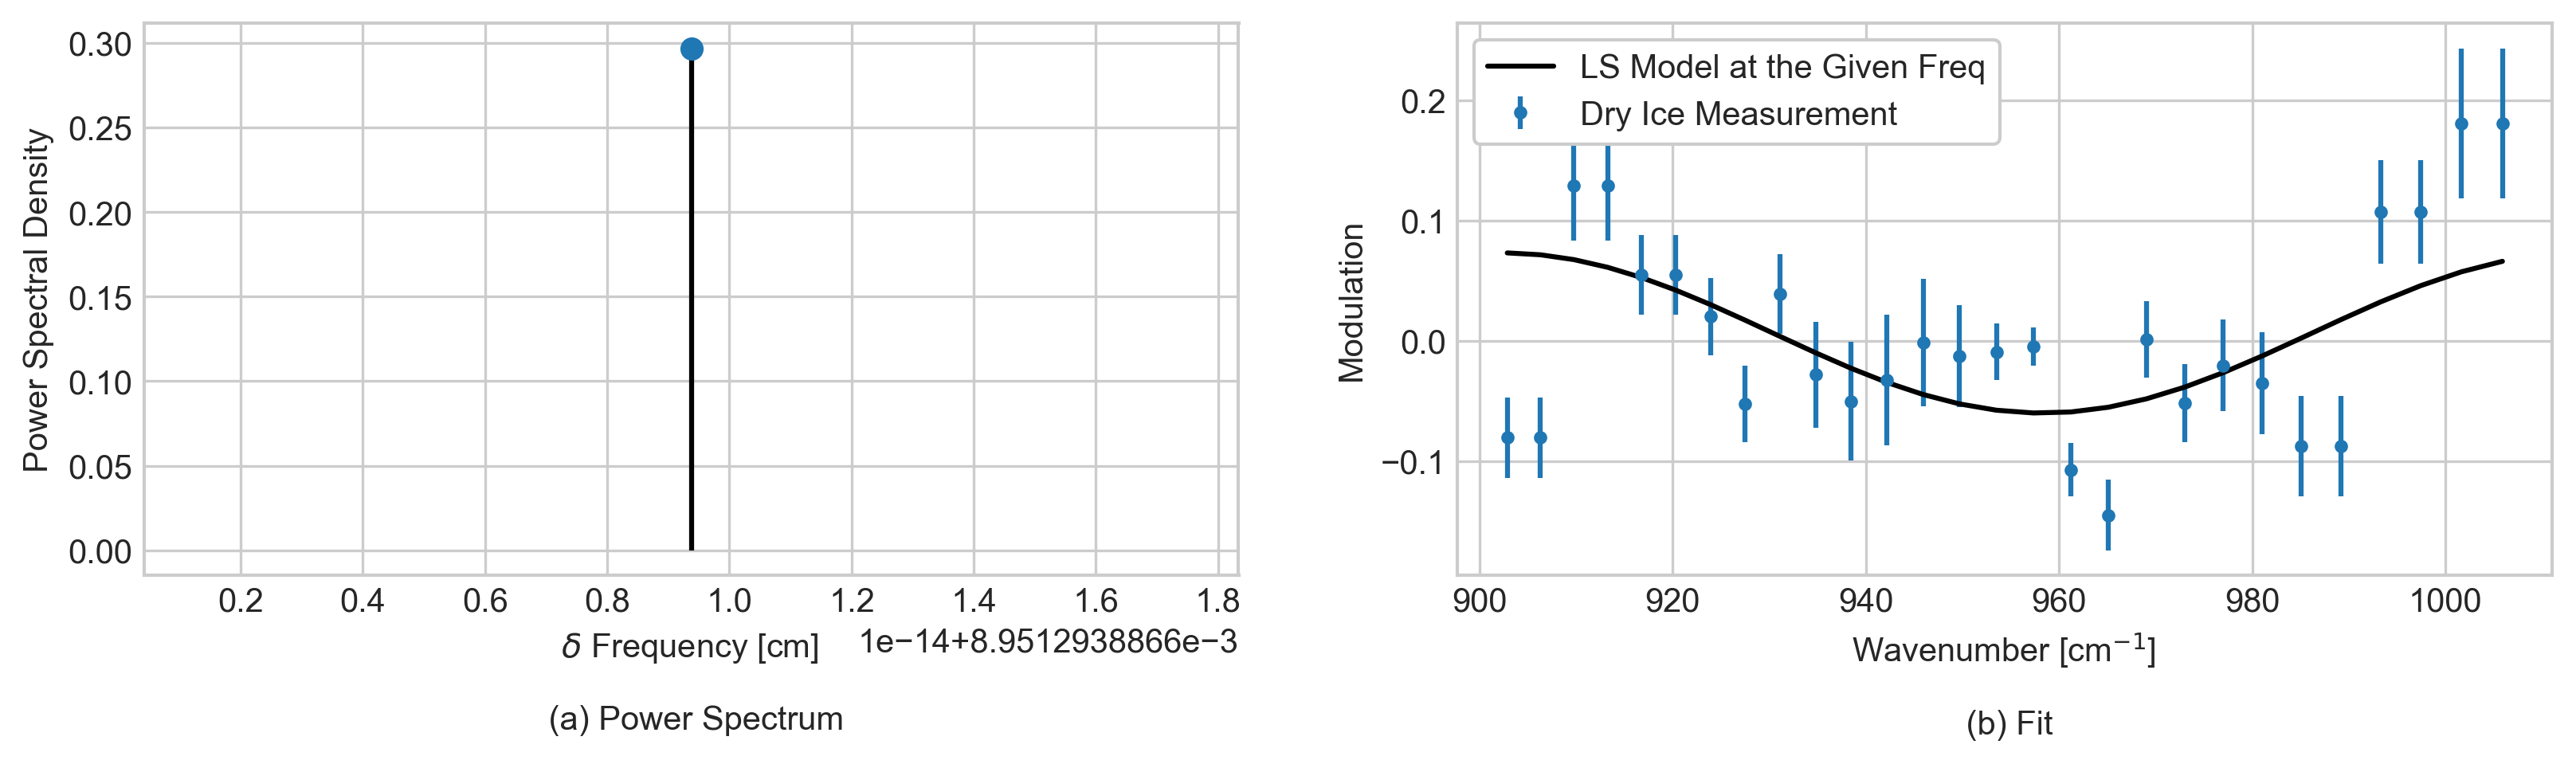

In [4929]:
plt.style.use('seaborn-whitegrid')

a = 3
j = 70
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]
print('expected retardance ' + str(freq))


x = wav[start:stop]
[y,dy] = MOD(a,j,R1_w[:,1],R2_w[:,1],E1_w[:,1],E2_w[:,1])



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5])

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))

[offset,q,u] = ls.model_parameters(best_frequency)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp_corr))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

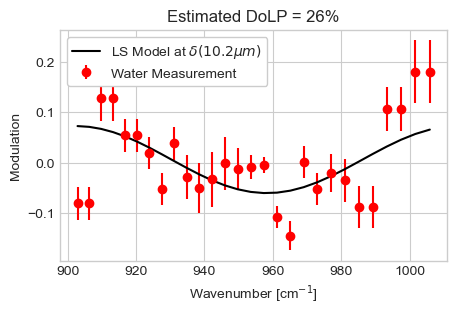

In [4930]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.plot(t_fit,y_fit,'k', label='LS Model at $\delta (10.2\mu m)$')
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Modulation')
plt.errorbar(x,y,yerr = dy,fmt='o',color='r' ,label='Water Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
plt.title("Estimated DoLP = 26%")
legend.get_frame().set_facecolor('w')
plt.show()

### 7.12.2023

In [4213]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.12.2023//'
angles = [-53.5,-45,-20,0,20,45,53.5]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "MoreWater" + str(angles[i]) + str('AOI_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [4214]:
for i in range(num):
    std1[i] = np.std(imgs1[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)

In [4215]:
im1 = np.zeros([num,3,256,320])
im2 = np.zeros([num,3,256,320])
for t in range(num):
    for i in range(3):
    
    #c1 = (imgs1[t] - np.mean(imgs1[t][200:230,25:50]))    #3C
    #c2 = (imgs2[t] - np.mean(imgs2[t][200:230,25:50]))    
    
        im1[t,i] = (imgs1[t][i] - np.mean(imgs1[t][i][200:230,250:300]))    
        im2[t,i] = (imgs2[t][i] - np.mean(imgs2[t][i][160:170,145:155]))   


In [4216]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [4217]:
responses = np.zeros([len(angles),3,len(waves)])
responses1 = np.zeros([len(angles),3,len(waves)])
responses2 = np.zeros([len(angles),3,len(waves)])
responses_err = np.zeros([len(angles),3,len(waves)])
responses_err1 = np.zeros([len(angles),3,len(waves)])
responses_err2 = np.zeros([len(angles),3,len(waves)])

for a in range(len(angles)):
    for i in range(3):
        p2 = pixel_registration(im2[a][i],cal_file2,waves,ymin2,ymax2)
        p1 = pixel_registration(im1[a][i],cal_file1,waves,ymin1,ymax1)
        s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
        s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

        err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
        responses[a,i]= (p1[y1-ymin1]+p2[y2-ymin2])
        responses_err[a,i]= err

        responses1[a,i]= p1[y1-ymin1]
        responses_err1[a,i]= s1[y1-ymin1]
        responses2[a,i]= p2[y2-ymin2]
        responses_err2[a,i]= s2[y2-ymin2]

In [4200]:
R1_ice = responses1
R2_ice = responses2
E1_ice = responses_err1
E2_ice = responses_err2

In [4212]:
R1_cap = responses1
R2_cap = responses2
E1_cap = responses_err1
E2_cap = responses_err2

In [4194]:
R1_w = responses1
R2_w = responses2
E1_w = responses_err1
E2_w = responses_err2

In [4206]:
R1_mix = responses1
R2_mix = responses2
E1_mix = responses_err1
E2_mix = responses_err2

In [4218]:
R1_morew = responses1
R2_morew = responses2
E1_morew = responses_err1
E2_morew = responses_err2

In [4219]:
aolp_ice = np.zeros([num,3,90])
dolp_ice = np.zeros([num,3,90])
prob_ice = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_ice[:,i],R2_ice[:,i],E1_ice[:,i],E2_ice[:,i])
            dolp_ice[a,i,j] = out[0]
            prob_ice[a,i,j] = out[4]
            aolp_ice[a,i,j] = out[1]
            #if np.aolp_ice[a,i,j] < 0:
             #   aolp_ice[a,i,j] = aolp_ice[a,i,j] + np.pi

aolp_w = np.zeros([num,3,90])
dolp_w = np.zeros([num,3,90])
prob_w = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_w[:,i],R2_w[:,i],E1_w[:,i],E2_w[:,i])
            dolp_w[a,i,j] = out[0]
            prob_w[a,i,j] = out[4]
            aolp_w[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi
            
aolp_m = np.zeros([num,3,90])
dolp_m = np.zeros([num,3,90])
prob_m = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_mix[:,i],R2_mix[:,i],E1_mix[:,i],E2_mix[:,i])
            dolp_m[a,i,j] = out[0]
            prob_m[a,i,j] = out[4]
            aolp_m[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi
            
aolp_cap = np.zeros([num,3,90])
dolp_cap = np.zeros([num,3,90])
prob_cap = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_cap[:,i],R2_cap[:,i],E1_cap[:,i],E2_cap[:,i])
            dolp_cap[a,i,j] = out[0]
            prob_cap[a,i,j] = out[4]
            aolp_cap[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi
            
aolp_morew = np.zeros([num,3,90])
dolp_morew = np.zeros([num,3,90])
prob_morew = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_morew[:,i],R2_morew[:,i],E1_morew[:,i],E2_morew[:,i])
            dolp_morew[a,i,j] = out[0]
            prob_morew[a,i,j] = out[4]
            aolp_morew[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi

In [4220]:
dolp_ice_std = np.zeros([num])
aolp_ice_std = np.zeros([num])
for i in range(num):
    dolp_ice_std = np.nanstd(dolp_ice,axis =1)
    aolp_ice_std = np.nanstd(aolp_ice,axis =1)


dolp_w_std = np.zeros([num])
aolp_w_std = np.zeros([num])
for i in range(num):
    dolp_w_std = np.nanstd(dolp_w,axis =1)
    aolp_w_std = np.nanstd(aolp_w,axis =1)
    
dolp_m_std = np.zeros([num])
aolp_m_std = np.zeros([num])
for i in range(num):
    dolp_m_std = np.nanstd(dolp_m,axis =1)
    aolp_m_std = np.nanstd(aolp_m,axis =1)

dolp_morew_std = np.zeros([num])
aolp_morew_std = np.zeros([num])
for i in range(num):
    dolp_morew_std = np.nanstd(dolp_morew,axis =1)
    aolp_morew_std = np.nanstd(aolp_morew,axis =1)
    
dolp_icecap_std = np.zeros([num])
aolp_icecap_std = np.zeros([num])
for i in range(num):
    dolp_icecap_std = np.nanstd(dolp_cap,axis =1)
    aolp_icecap_std = np.nanstd(aolp_cap,axis =1)

Text(0, 0.5, 'DoLP [%]')

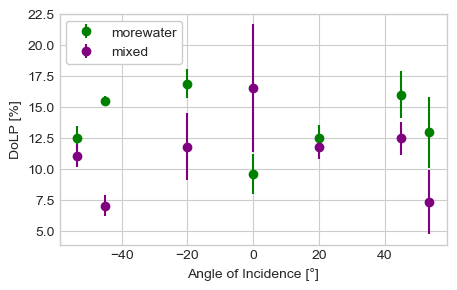

In [4221]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

i = 70
j = 55
#plt.errorbar(angles,dolp_ice[:,0,i]*100,yerr=dolp_ice_std[:,i]*100,fmt='o',color='b',label='ice')
#plt.errorbar(angles,dolp_w[:,0,i]*100,yerr=dolp_w_std[:,i]*100,fmt='o',color='r',label='water')
#plt.errorbar(angles,dolp_cap[:,0,i]*100,yerr=dolp_icecap_std[:,i]*100,fmt='o',color='orange',label='ice cap')
plt.errorbar(angles,dolp_morew[:,1,i]*100,yerr=dolp_morew_std[:,i]*100,fmt='o',color='green',label='morewater')
plt.errorbar(angles,dolp_m[:,1,i]*100,yerr=dolp_m_std[:,i]*100,fmt='o',color='purple',label='mixed')
#plt.errorbar(angles,dolp_morew[:,0,j]*100,yerr=dolp_morew_std[:,j]*100,fmt='x',color='green')#,label='morewater')
#plt.errorbar(angles,dolp_m[:,0,j]*100,yerr=dolp_m_std[:,j]*100,fmt='x',color='purple')#,label='mixed')

#plt.errorbar(angles,dolp_w[:,0,22]*100,yerr=dolp_w_std[:,22]*100,fmt='x',color='b')
#plt.errorbar(angles,dolp_w[:,0,70]*100,yerr=dolp_w_std[:,70]*100,fmt='x',color='r')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

In [4222]:
plt.style.use('seaborn-whitegrid')

<ErrorbarContainer object of 3 artists>

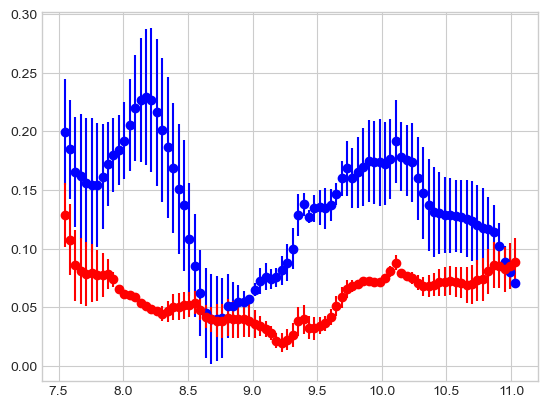

In [4223]:
i = 4
plt.errorbar(lambda_c[6:90],np.mean(dolp_ice[i,:,6:],axis=0),yerr=dolp_ice_std[i,6:],fmt='o',color='blue')
plt.errorbar(lambda_c[6:90],np.mean(dolp_w[i,:,6:],axis=0),yerr=dolp_w_std[i,6:],fmt='o',color='red')

<ErrorbarContainer object of 3 artists>

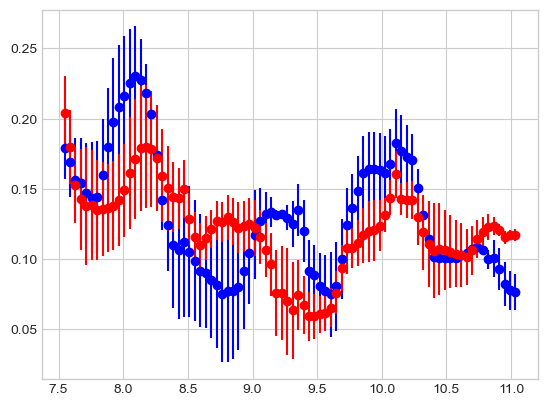

In [4224]:
i = 5
plt.errorbar(lambda_c[6:90],np.mean(dolp_morew[i,:,6:],axis=0),yerr=dolp_morew_std[i,6:],fmt='o',color='blue')
plt.errorbar(lambda_c[6:90],np.mean(dolp_m[i,:,6:],axis=0),yerr=dolp_m_std[i,6:],fmt='o',color='red')

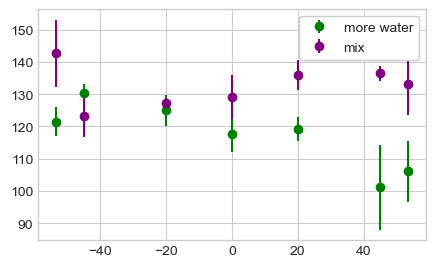

In [4225]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

i = 24

plt.errorbar(angles,np.rad2deg(aolp_morew[:,1,i])+180,yerr=np.rad2deg(aolp_morew_std[:,i]),fmt='o',color='green',label='more water')
plt.errorbar(angles,np.rad2deg(aolp_m[:,1,i])+180,yerr=np.rad2deg(aolp_m_std[:,i]),fmt='o',color='purple',label='mix')
#plt.errorbar(angles,np.rad2deg(aolp_ice[:,0,56]),yerr=np.rad2deg(aolp_ice_std[:,56]),fmt='o',color='orange',label='9.6um')
#plt.errorbar(angles,np.rad2deg(aolp_w[:,0,34]),yerr=np.rad2deg(aolp_w_std[:,34]),fmt='x',color='b')
#plt.errorbar(angles,np.rad2deg(aolp_w[:,0,70]),yerr=np.rad2deg(aolp_w_std[:,70]),fmt='x',color='r')
#plt.errorbar(angles,np.rad2deg(aolp_w[:,0,56]) ,yerr=np.rad2deg(aolp_w_std[:,56]),fmt='x',color='orange')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')

In [4235]:
calibration_path = 'C:\\Users\\khart\\Documents\\Summer2022Campaign\\IRCSP1\\Water_Meas\\7.12.2023\\'

In [4236]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
   # nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]
    #contextfit = file['/radiometric/contextfit'][()]

In [4242]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3])
bt2_ice = np.zeros([num,3])
bt3_ice = np.zeros([num,3])
bt1_w = np.zeros([num,3])
bt2_w = np.zeros([num,3])
bt3_w = np.zeros([num,3])
bt1_m = np.zeros([num,3])
bt2_m = np.zeros([num,3])
bt3_m = np.zeros([num,3])
bt1_morew = np.zeros([num,3])
bt2_morew = np.zeros([num,3])
bt3_morew = np.zeros([num,3])
bt1_cap = np.zeros([num,3])
bt2_cap = np.zeros([num,3])
bt3_cap = np.zeros([num,3])
for n in range(3):
    bt1_ice[:,n] = get_BT(15,ii,ff,R1_ice,R2_ice,n)[0]
    bt2_ice[:,n] = get_BT(20,ii,ff,R1_ice,R2_ice,n)[0]
    bt3_ice[:,n] = get_BT(25,ii,ff,R1_ice,R2_ice,n)[0]
    bt1_w[:,n] = get_BT(15,ii,ff,R1_w,R2_w,n)[0]
    bt2_w[:,n] = get_BT(20,ii,ff,R1_w,R2_w,n)[0]
    bt3_w[:,n] = get_BT(25,ii,ff,R1_w,R2_w,n)[0]
    bt1_m[:,n] = get_BT(15,ii,ff,R1_mix,R2_mix,n)[0]
    bt2_m[:,n] = get_BT(20,ii,ff,R1_mix,R2_mix,n)[0]
    bt3_m[:,n] = get_BT(25,ii,ff,R1_mix,R2_mix,n)[0]    
    bt1_morew[:,n] = get_BT(15,ii,ff,R1_morew,R2_morew,n)[0]
    bt2_morew[:,n] = get_BT(20,ii,ff,R1_morew,R2_morew,n)[0]
    bt3_morew[:,n] = get_BT(25,ii,ff,R1_morew,R2_morew,n)[0]
    bt1_cap[:,n] = get_BT(15,ii,ff,R1_cap,R2_cap,n)[0]
    bt2_cap[:,n] = get_BT(20,ii,ff,R1_cap,R2_cap,n)[0]
    bt3_cap[:,n] = get_BT(25,ii,ff,R1_cap,R2_cap,n)[0]
    
    
    
et1_ice = np.std(bt1_ice,axis=1)
et2_ice = np.std(bt2_ice,axis=1)
et3_ice = np.std(bt3_ice,axis=1)
et1_w = np.std(bt1_w,axis=1)
et2_w = np.std(bt2_w,axis=1)
et3_w = np.std(bt3_w,axis=1)
et1_morew = np.std(bt1_morew,axis=1)
et2_morew = np.std(bt2_morew,axis=1)
et3_morew = np.std(bt3_morew,axis=1)
et1_m = np.std(bt1_m,axis=1)
et2_m = np.std(bt2_m,axis=1)
et3_m = np.std(bt3_m,axis=1)
et1_cap = np.std(bt1_cap,axis=1)
et2_cap = np.std(bt2_cap,axis=1)
et3_cap = np.std(bt3_cap,axis=1)

In [4238]:
np.shape(R1_cap)

(7, 3, 120)

In [4239]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3,90])
bt1_cap = np.zeros([num,3,90])
bt1_w = np.zeros([num,3,90])
bt1_mix = np.zeros([num,3,90])
bt1_morew = np.zeros([num,3,90])

for j in range(90):
    for n in range(3):
        bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_cap[:,n,j] = get_BT(j,ii,ff,R1_cap,R2_cap,n)[0]
        bt1_w[:,n,j] = get_BT(j,ii,ff,R1_w,R2_w,n)[0]
        bt1_mix[:,n,j] = get_BT(j,ii,ff,R1_mix,R2_mix,n)[0]
        bt1_morew[:,n,j] = get_BT(j,ii,ff,R1_morew,R2_morew,n)[0]


et1_ice = np.std(bt1_ice,axis=1)
et1_w = np.std(bt1_w,axis=1)

Text(0, 0.5, 'Brightness Temperature Retrieval')

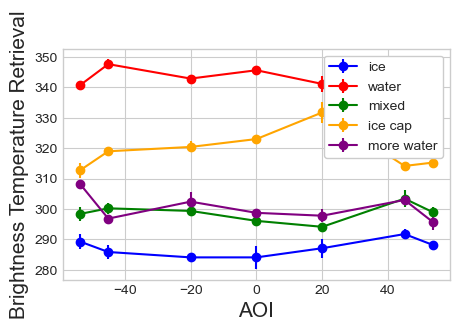

In [4243]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,bt1_ice[:,0],marker = 'o',yerr=et1_ice,color = 'b',label = 'ice')
plt.errorbar(angles,bt1_w[:,0],marker='o',yerr=et1_w,color = 'r',label = 'water')
plt.errorbar(angles,bt1_m[:,0],marker='o',yerr=et1_m,color = 'green',label = 'mixed')
plt.errorbar(angles,bt1_cap[:,0],marker='o',yerr=et1_cap,color = 'orange',label = 'ice cap')
plt.errorbar(angles,bt1_morew[:,0],marker='o',yerr=et1_morew,color = 'purple',label = 'more water')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel("AOI",fontsize=15)
plt.ylabel("Brightness Temperature Retrieval",fontsize=15)

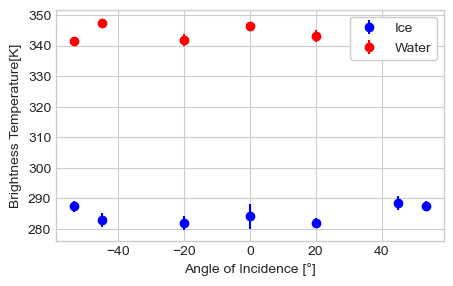

In [4241]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.errorbar(angles,np.mean(bt1_ice[:,0,:],axis=1),yerr=np.mean(et1_ice[:,:],axis=1),fmt='o',color='b',label='Ice')
plt.errorbar(angles,np.mean(bt1_w[:,0,:],axis=1),yerr=np.mean(et1_w[:,:],axis=1),fmt='o',color='r',label="Water")
plt.ylabel('Brightness Temperature[K]')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')

Text(0, 0.5, 'Brightness Temperature Retrieval')

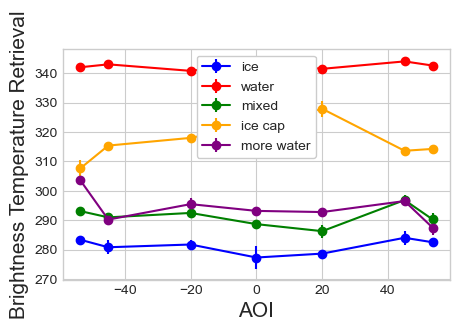

In [3368]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,bt3_ice[:,0],marker = 'o',yerr=et3_ice,color = 'b',label = 'ice')
plt.errorbar(angles,bt3_w[:,0],marker='o',yerr=et3_w,color = 'r',label = 'water')
plt.errorbar(angles,bt3_m[:,0],marker='o',yerr=et3_m,color = 'green',label = 'mixed')
plt.errorbar(angles,bt3_cap[:,0],marker='o',yerr=et3_cap,color = 'orange',label = 'ice cap')
plt.errorbar(angles,bt3_morew[:,0],marker='o',yerr=et3_morew,color = 'purple',label = 'more water')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel("AOI",fontsize=15)
plt.ylabel("Brightness Temperature Retrieval",fontsize=15)

Text(0, 0.5, 'Brightness Temperature Retrieval')

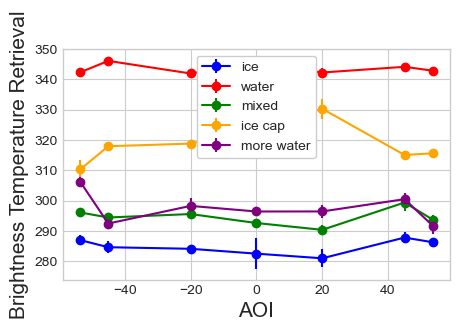

In [3367]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

plt.errorbar(angles,bt2_ice[:,0],marker = 'o',yerr=et2_ice,color = 'b',label = 'ice')
plt.errorbar(angles,bt2_w[:,0],marker='o',yerr=et2_w,color = 'r',label = 'water')
plt.errorbar(angles,bt2_m[:,0],marker='o',yerr=et2_m,color = 'green',label = 'mixed')
plt.errorbar(angles,bt2_cap[:,0],marker='o',yerr=et2_cap,color = 'orange',label = 'ice cap')
plt.errorbar(angles,bt2_morew[:,0],marker='o',yerr=et2_morew,color = 'purple',label = 'more water')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.xlabel("AOI",fontsize=15)
plt.ylabel("Brightness Temperature Retrieval",fontsize=15)

-53.5
10.235294117647058
expected retardance 0.008951293886609384
prob = 0.022911447122666354
best freq = 0.008951293886609384
dolp = 0.20506212060226867
aolp = 0.5904469938510325


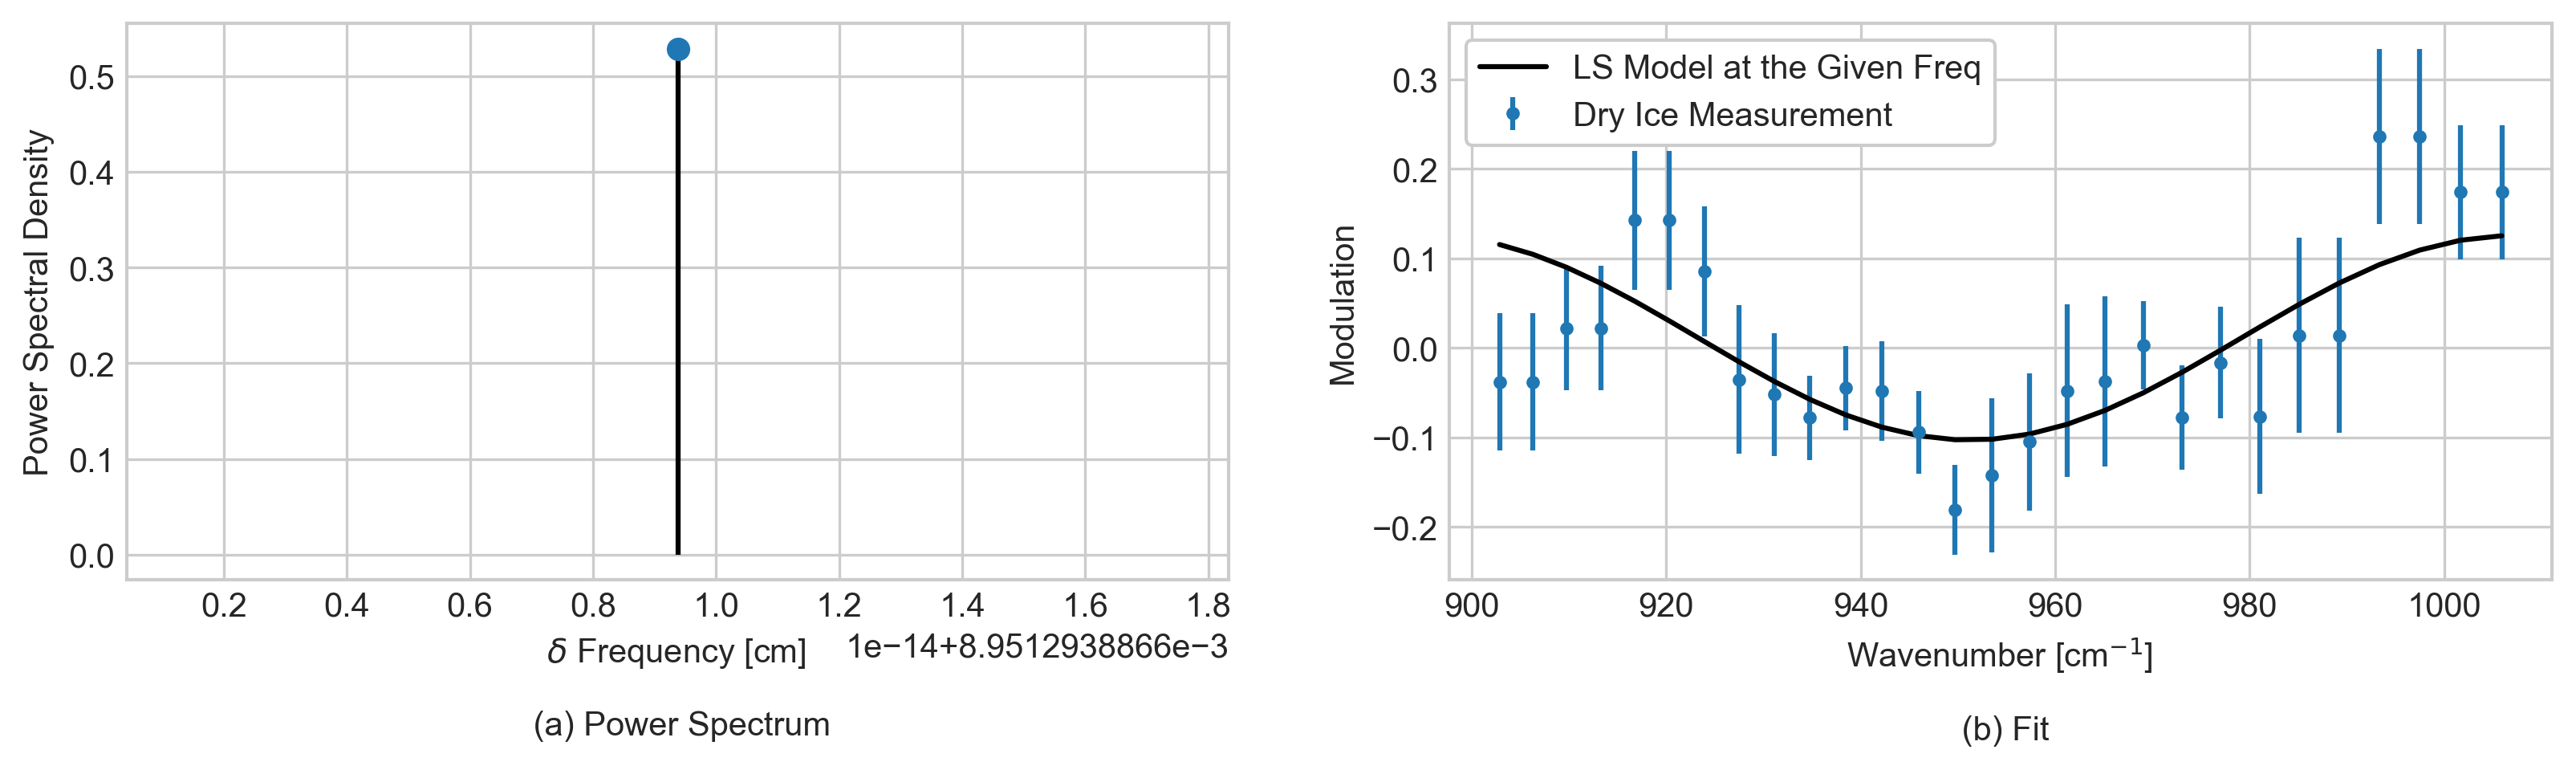

In [3354]:
plt.style.use('seaborn-whitegrid')

a = 0
j = 70
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]
print('expected retardance ' + str(freq))


x = wav[start:stop]
[y,dy] = MOD(a,j,R1_mix[:,1],R2_mix[:,1],E1_mix[:,1],E2_mix[:,1])



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5])

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))

[offset,q,u] = ls.model_parameters(best_frequency)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp_corr))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

-53.5
10.235294117647058
expected retardance 0.008951293886609384
prob = 0.014846919801772678
best freq = 0.008951293886609384
dolp = 0.24943749280745472
aolp = 0.7919476783747197


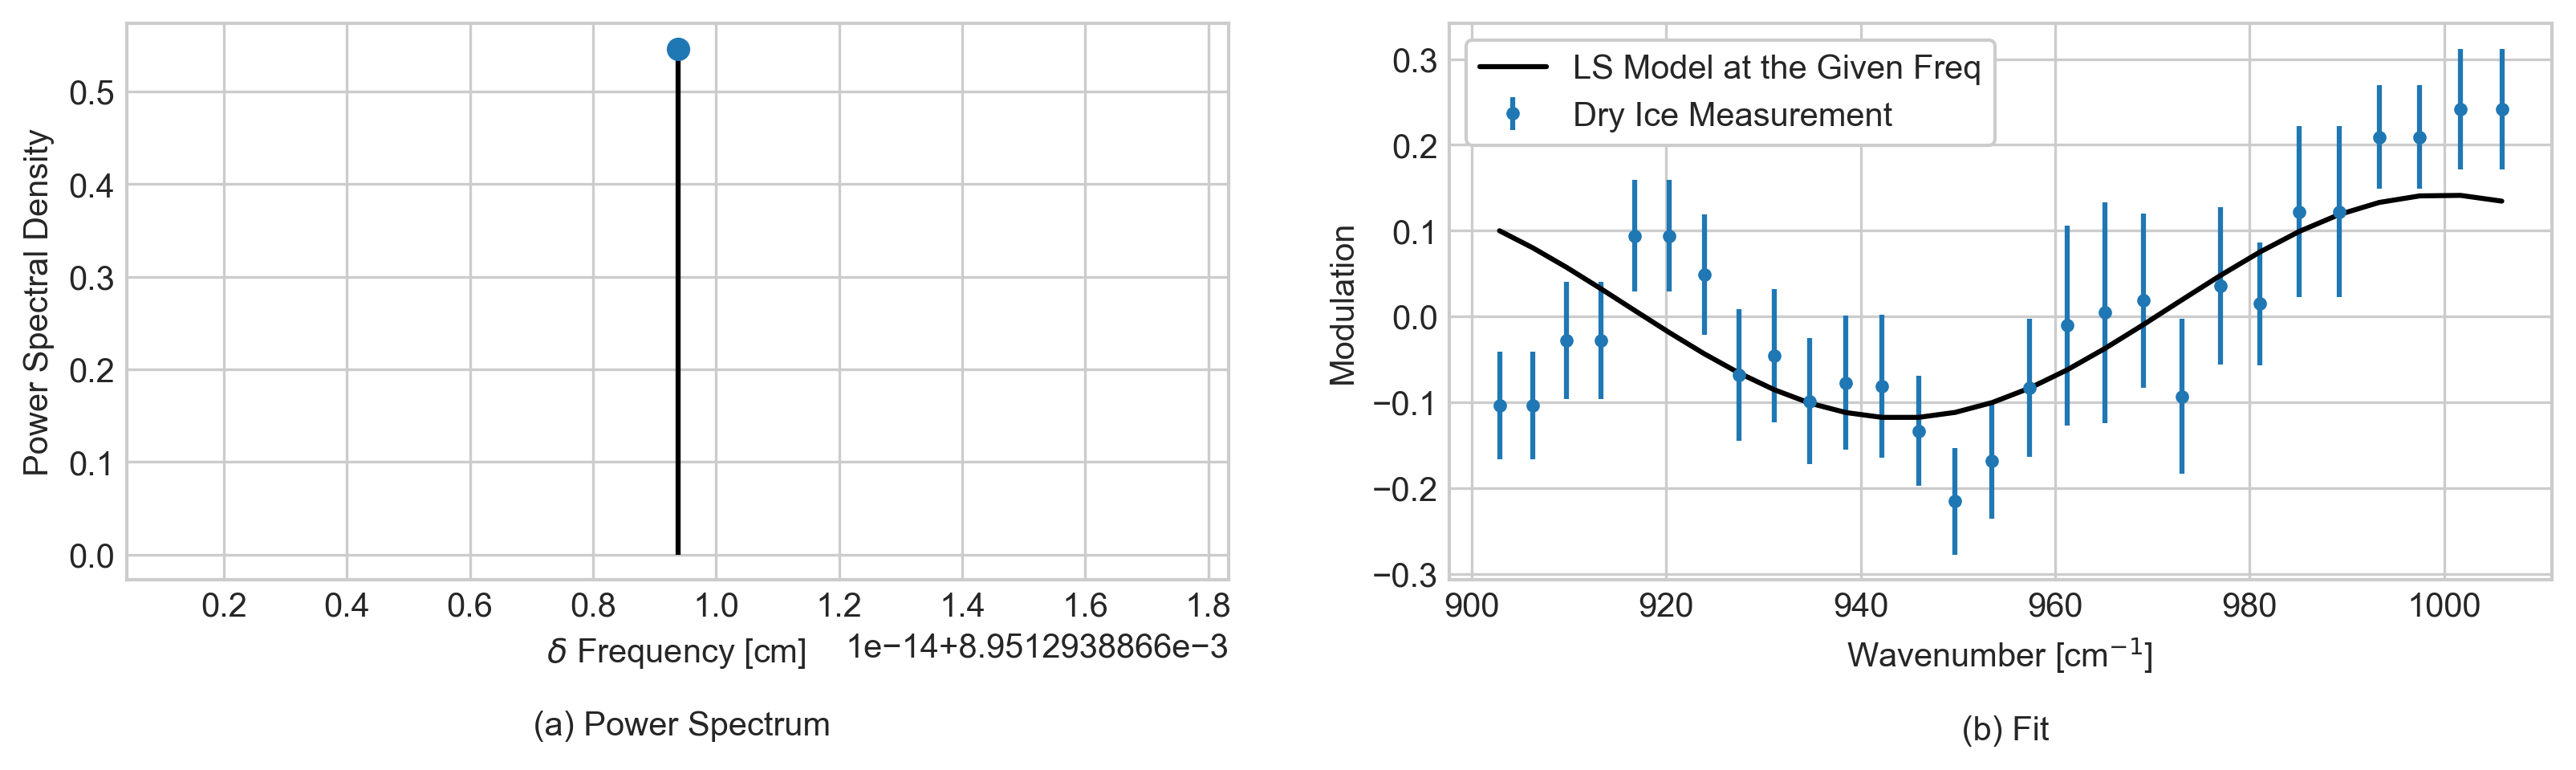

In [3355]:
plt.style.use('seaborn-whitegrid')

a = 0
j = 70
print(angles[a])
print(lambda_c[j])
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
freq = carrier[j]
print('expected retardance ' + str(freq))


x = wav[start:stop]
[y,dy] = MOD(a,j,R1_morew[:,1],R2_morew[:,1],E1_morew[:,1],E2_morew[:,1])



ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5])

best_frequency = frequency[np.argmax(power)]
prob = ls.false_alarm_probability(power[np.argmax(power)])  
print('prob = ' + str(prob))
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print("best freq = "+ str(best_frequency))

[offset,q,u] = ls.model_parameters(best_frequency)
U = u
Q = q
dolp = (((U)**2 +(Q)**2)**0.5)
aolp = 0.5*np.arctan2(U,Q)
aolp_corr = aolp - phase[j]
idx = find_nearest(W_ang, aolp_corr)
eff = W[j,idx]
dolp_corr = dolp/eff
print('dolp = ' + str(dolp_corr))
print('aolp = ' + str(aolp_corr))

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power, 'k',basefmt = 'k')
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='LS Model at the Given Freq')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Dry Ice Measurement')
#axes[1].set_title('Dry Ice -5deg AOI at 8um ')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

### 7.13.2023

In [4263]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.13.2023//'
angles = [-53.5,-45,-20,0,20,45,53.5]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)

for j in range(3):
    for i in range(num):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "MoreWater" + str(angles[i]) + str('AOI_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i,j] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i,j] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i,j] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [4264]:
for i in range(num):
    std1[i] = np.std(imgs1[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)

In [4265]:
im1 = np.zeros([num,3,256,320])
im2 = np.zeros([num,3,256,320])
for t in range(num):
    for i in range(3):
    
    #c1 = (imgs1[t] - np.mean(imgs1[t][200:230,25:50]))    #3C
    #c2 = (imgs2[t] - np.mean(imgs2[t][200:230,25:50]))    
    
        im1[t,i] = (imgs1[t][i] - np.mean(imgs1[t][i][200:230,250:300]))    
        im2[t,i] = (imgs2[t][i] - np.mean(imgs2[t][i][160:170,145:155]))   


In [4266]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [4267]:
responses = np.zeros([len(angles),3,len(waves)])
responses1 = np.zeros([len(angles),3,len(waves)])
responses2 = np.zeros([len(angles),3,len(waves)])
responses_err = np.zeros([len(angles),3,len(waves)])
responses_err1 = np.zeros([len(angles),3,len(waves)])
responses_err2 = np.zeros([len(angles),3,len(waves)])

for a in range(len(angles)):
    for i in range(3):
        p2 = pixel_registration(im2[a][i],cal_file2,waves,ymin2,ymax2)
        p1 = pixel_registration(im1[a][i],cal_file1,waves,ymin1,ymax1)
        s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
        s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

        err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
        responses[a,i]= (p1[y1-ymin1]+p2[y2-ymin2])
        responses_err[a,i]= err

        responses1[a,i]= p1[y1-ymin1]
        responses_err1[a,i]= s1[y1-ymin1]
        responses2[a,i]= p2[y2-ymin2]
        responses_err2[a,i]= s2[y2-ymin2]

In [4256]:
R1_ice = responses1
R2_ice = responses2
E1_ice = responses_err1
E2_ice = responses_err2

In [4262]:
R1_m = responses1
R2_m = responses2
E1_m = responses_err1
E2_m = responses_err2

In [4268]:
R1_morew = responses1
R2_morew = responses2
E1_morew = responses_err1
E2_morew = responses_err2

In [4250]:
R1_w = responses1
R2_w = responses2
E1_w = responses_err1
E2_w = responses_err2

In [3973]:
aolp_ice = np.zeros([num,3,90])
dolp_ice = np.zeros([num,3,90])
prob_ice = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_ice[:,i],R2_ice[:,i],E1_ice[:,i],E2_ice[:,i])
            dolp_ice[a,i,j] = out[0]
            prob_ice[a,i,j] = out[4]
            aolp_ice[a,i,j] = out[1]
            #if np.aolp_ice[a,i,j] < 0:
             #   aolp_ice[a,i,j] = aolp_ice[a,i,j] + np.pi

aolp_w = np.zeros([num,3,90])
dolp_w = np.zeros([num,3,90])
prob_w = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_w[:,i],R2_w[:,i],E1_w[:,i],E2_w[:,i])
            dolp_w[a,i,j] = out[0]
            prob_w[a,i,j] = out[4]
            aolp_w[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi
            
aolp_m = np.zeros([num,3,90])
dolp_m = np.zeros([num,3,90])
prob_m = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_mix[:,i],R2_mix[:,i],E1_mix[:,i],E2_mix[:,i])
            dolp_m[a,i,j] = out[0]
            prob_m[a,i,j] = out[4]
            aolp_m[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi
                     
aolp_morew = np.zeros([num,3,90])
dolp_morew = np.zeros([num,3,90])
prob_morew = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_morew[:,i],R2_morew[:,i],E1_morew[:,i],E2_morew[:,i])
            dolp_morew[a,i,j] = out[0]
            prob_morew[a,i,j] = out[4]
            aolp_morew[a,i,j] = out[1]
            #if aolp_w[a,i,j] < 0:
            #    aolp_w[a,i,j] = aolp_w[a,i,j] + np.pi

In [3975]:
dolp_ice_std = np.zeros([num])
aolp_ice_std = np.zeros([num])
for i in range(num):
    dolp_ice_std = np.nanstd(dolp_ice,axis =1)
    aolp_ice_std = np.nanstd(aolp_ice,axis =1)


dolp_w_std = np.zeros([num])
aolp_w_std = np.zeros([num])
for i in range(num):
    dolp_w_std = np.nanstd(dolp_w,axis =1)
    aolp_w_std = np.nanstd(aolp_w,axis =1)
    
dolp_m_std = np.zeros([num])
aolp_m_std = np.zeros([num])
for i in range(num):
    dolp_m_std = np.nanstd(dolp_m,axis =1)
    aolp_m_std = np.nanstd(aolp_m,axis =1)

dolp_morew_std = np.zeros([num])
aolp_morew_std = np.zeros([num])
for i in range(num):
    dolp_morew_std = np.nanstd(dolp_morew,axis =1)
    aolp_morew_std = np.nanstd(aolp_morew,axis =1)

Text(0, 0.5, 'DoLP [%]')

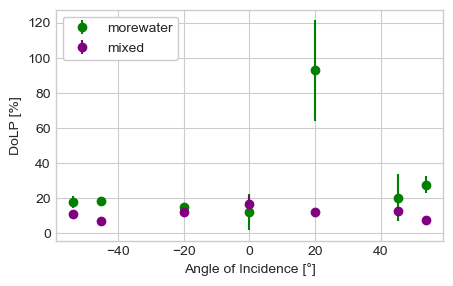

In [3976]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

i = 70
j = 55
#plt.errorbar(angles,dolp_ice[:,0,i]*100,yerr=dolp_ice_std[:,i]*100,fmt='o',color='b',label='ice')
#plt.errorbar(angles,dolp_w[:,0,i]*100,yerr=dolp_w_std[:,i]*100,fmt='o',color='r',label='water')
#plt.errorbar(angles,dolp_cap[:,0,i]*100,yerr=dolp_icecap_std[:,i]*100,fmt='o',color='orange',label='ice cap')
plt.errorbar(angles,dolp_morew[:,1,i]*100,yerr=dolp_morew_std[:,i]*100,fmt='o',color='green',label='morewater')
plt.errorbar(angles,dolp_m[:,1,i]*100,yerr=dolp_m_std[:,i]*100,fmt='o',color='purple',label='mixed')
#plt.errorbar(angles,dolp_morew[:,0,j]*100,yerr=dolp_morew_std[:,j]*100,fmt='x',color='green')#,label='morewater')
#plt.errorbar(angles,dolp_m[:,0,j]*100,yerr=dolp_m_std[:,j]*100,fmt='x',color='purple')#,label='mixed')

#plt.errorbar(angles,dolp_w[:,0,22]*100,yerr=dolp_w_std[:,22]*100,fmt='x',color='b')
#plt.errorbar(angles,dolp_w[:,0,70]*100,yerr=dolp_w_std[:,70]*100,fmt='x',color='r')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

<ErrorbarContainer object of 3 artists>

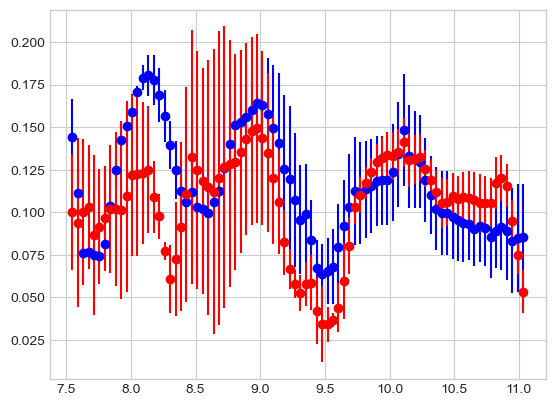

In [3992]:
i = 2
plt.errorbar(lambda_c[6:90],np.mean(dolp_m[i,:,6:],axis=0),yerr=dolp_m_std[i,6:],fmt='o',color='blue')
plt.errorbar(lambda_c[6:90],np.mean(dolp_w[i,:,6:],axis=0),yerr=dolp_w_std[i,6:],fmt='o',color='red')


In [4269]:
ii = 0
ff = num

bt1_ice = np.zeros([num,3,90])
bt1_cap = np.zeros([num,3,90])
bt1_w = np.zeros([num,3,90])
bt1_mix = np.zeros([num,3,90])
bt1_morew = np.zeros([num,3,90])

for j in range(90):
    for n in range(3):
        bt1_ice[:,n,j] = get_BT(j,ii,ff,R1_ice,R2_ice,n)[0]
        bt1_cap[:,n,j] = get_BT(j,ii,ff,R1_cap,R2_cap,n)[0]
        bt1_w[:,n,j] = get_BT(j,ii,ff,R1_w,R2_w,n)[0]
        bt1_mix[:,n,j] = get_BT(j,ii,ff,R1_mix,R2_mix,n)[0]
        bt1_morew[:,n,j] = get_BT(j,ii,ff,R1_morew,R2_morew,n)[0]


et1_ice = np.std(bt1_ice,axis=1)
et1_w = np.std(bt1_w,axis=1)

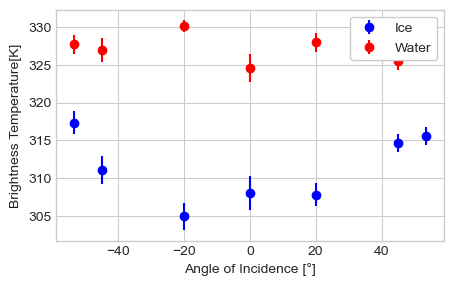

In [4270]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)
plt.errorbar(angles,np.mean(bt1_ice[:,0,:],axis=1),yerr=np.mean(et1_ice[:,:],axis=1),fmt='o',color='b',label='Ice')
plt.errorbar(angles,np.mean(bt1_w[:,0,:],axis=1),yerr=np.mean(et1_w[:,:],axis=1),fmt='o',color='r',label="Water")
plt.ylabel('Brightness Temperature[K]')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper right")
legend.get_frame().set_facecolor('w')

### 7.14.2023

In [4295]:
path = 'C://Users//khart//Documents//Summer2022Campaign//IRCSP1//Water_Meas//7.14.2023//'
angles = [-53.5,-45,-20,0,20,45,53.5]
#capture = np.arange(10,50,1)
num = len(angles)
imgs1 = np.zeros([num,3,256,320])
imgs2 = np.zeros([num,3,256,320])
imgs3 = np.zeros([num,3,256,320])
std1 = np.zeros([num,256,320])
std2 = np.zeros([num,256,320])
t1 = np.zeros(num)
t2 = np.zeros(num)
t3 = np.zeros(num)


for i in range(num):
    for j in range(3):
    #with h5py.File(path + 'Capture' + str(capture[i]) + '.h5', "r") as f:
        with h5py.File(path + "WaterLayer" + str(angles[i]) + str('AOI_') + str(j+1) + str('.h5'), "r") as f:
                imgs1[i] = np.mean(np.array(f[list(f.keys())[2]]),axis=0)
                imgs2[i] = np.mean(np.array(f[list(f.keys())[3]]),axis=0)
                imgs3[i] = np.mean(np.array(f[list(f.keys())[4]]),axis = 0)
                std1[i] = np.std(np.array(f[list(f.keys())[2]]),axis = 0)
                std2[i] = np.std(np.array(f[list(f.keys())[3]]),axis=0)
                t1[i] = np.array(f[list(f.keys())[8]])
                t2[i] = np.array(f[list(f.keys())[9]])
                t3[i] = np.array(f[list(f.keys())[10]])


In [4296]:
for i in range(num):
    std1[i] = np.std(imgs1[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)
    std2[i] = np.std(imgs2[i],axis =0)

In [4297]:
im1 = np.zeros([num,3,256,320])
im2 = np.zeros([num,3,256,320])
for t in range(num):
    for i in range(3):
    
    #c1 = (imgs1[t] - np.mean(imgs1[t][200:230,25:50]))    #3C
    #c2 = (imgs2[t] - np.mean(imgs2[t][200:230,25:50]))    
    
        im1[t,i] = (imgs1[t][i] - np.mean(imgs1[t][i][200:230,250:300]))    
        im2[t,i] = (imgs2[t][i] - np.mean(imgs2[t][i][160:170,145:155]))   


In [4298]:
def f(T, A, B): # this is your 'straight line' y=f(x)
    return A*T + B

def pixel_registration(array,cal_file,waves,ymin,ymax):
    #import cal file
    cal =  h5py.File(cal_file, "r")
    ROI =  list(cal['pixel_registration/ROI'])
    pa  =  list(cal['pixel_registration/fitparams'])

    array=array[ymin:ymax,ROI[0]:ROI[1]]
    
    new = np.zeros([len(array),len(waves)])
    for i in range(len(array)):
        for l in range(len(waves)):    
            w=  waves[l]
            j = int(round(f(w,pa[0],pa[1])))
            values = array[i,j-1:j+1]
            value = np.mean(values)
            new[i,l] = value
    return(new)

In [4299]:
responses = np.zeros([len(angles),3,len(waves)])
responses1 = np.zeros([len(angles),3,len(waves)])
responses2 = np.zeros([len(angles),3,len(waves)])
responses_err = np.zeros([len(angles),3,len(waves)])
responses_err1 = np.zeros([len(angles),3,len(waves)])
responses_err2 = np.zeros([len(angles),3,len(waves)])

for a in range(len(angles)):
    for i in range(3):
        p2 = pixel_registration(im2[a][i],cal_file2,waves,ymin2,ymax2)
        p1 = pixel_registration(im1[a][i],cal_file1,waves,ymin1,ymax1)
        s2 = pixel_registration(std2[a],cal_file2,waves,ymin2,ymax2)
        s1 = pixel_registration(std1[a],cal_file1,waves,ymin1,ymax1)

        err = np.sqrt((s2[y2-ymin2])**2+(s1[y1-ymin1])**2)
        responses[a,i]= (p1[y1-ymin1]+p2[y2-ymin2])
        responses_err[a,i]= err

        responses1[a,i]= p1[y1-ymin1]
        responses_err1[a,i]= s1[y1-ymin1]
        responses2[a,i]= p2[y2-ymin2]
        responses_err2[a,i]= s2[y2-ymin2]

In [4288]:
R1_ice = responses1
R2_ice = responses2
E1_ice = responses_err1
E2_ice = responses_err2

In [4294]:
R1_smallice = responses1
R2_smallice = responses2
E1_smallice = responses_err1
E2_smallice = responses_err2

In [4282]:
R1_w = responses1
R2_w = responses2
E1_w = responses_err1
E2_w = responses_err2

In [4300]:
R1_wl = responses1
R2_wl = responses2
E1_wl = responses_err1
E2_wl = responses_err2

In [4276]:
R1_thick = responses1
R2_thick = responses2
E1_thick = responses_err1
E2_thick = responses_err2

In [4301]:
aolp_ice = np.zeros([num,3,90])
dolp_ice = np.zeros([num,3,90])
prob_ice = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_ice[:,i],R2_ice[:,i],E1_ice[:,i],E2_ice[:,i])
            dolp_ice[a,i,j] = out[0]
            prob_ice[a,i,j] = out[4]
            aolp_ice[a,i,j] = out[1]
            if out[1] < 0:
                aolp_ice[a,i,j] = out[1] + np.pi
            else:
                aolp_ice[a,i,j] = out[1]

aolp_w = np.zeros([num,3,90])
dolp_w = np.zeros([num,3,90])
prob_w = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_w[:,i],R2_w[:,i],E1_w[:,i],E2_w[:,i])
            dolp_w[a,i,j] = out[0]
            prob_w[a,i,j] = out[4]
            aolp_w[a,i,j] = out[1]
            if out[1] < 0:
                aolp_w[a,i,j] = out[1] + np.pi
            else:
                aolp_w[a,i,j] = out[1]
            
aolp_wl = np.zeros([num,3,90])
dolp_wl = np.zeros([num,3,90])
prob_wl = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_wl[:,i],R2_wl[:,i],E1_wl[:,i],E2_wl[:,i])
            dolp_wl[a,i,j] = out[0]
            prob_wl[a,i,j] = out[4]
            aolp_wl[a,i,j] = out[1]
            if out[1] < 0:
                aolp_wl[a,i,j] = out[1] + np.pi
            else:
                aolp_wl[a,i,j] = out[1]
                     
aolp_smallice = np.zeros([num,3,90])
dolp_smallice = np.zeros([num,3,90])
prob_smallice = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_smallice[:,i],R2_smallice[:,i],E1_smallice[:,i],E2_smallice[:,i])
            dolp_smallice[a,i,j] = out[0]
            prob_smallice[a,i,j] = out[4]
            if out[1] < 0:
                aolp_smallice[a,i,j] = out[1] + np.pi
            else:
                aolp_smallice[a,i,j] = out[1]
            
        
                     
aolp_thick = np.zeros([num,3,90])
dolp_thick = np.zeros([num,3,90])
prob_thick = np.zeros([num,3,90])
for a in range(len(angles)):
    for i in range(3):
        for j in range(6,90):
            out = LombModel(a,j,W,R1_thick[:,i],R2_thick[:,i],E1_thick[:,i],E2_thick[:,i])
            dolp_thick[a,i,j] = out[0]
            prob_thick[a,i,j] = out[4]
            aolp_thick[a,i,j] = out[1]
            if out[1] < 0:
                aolp_thick[a,i,j] = out[1] + np.pi
            else:
                aolp_thick[a,i,j] = out[1]

In [4302]:
dolp_ice_std = np.zeros([num])
aolp_ice_std = np.zeros([num])
for i in range(num):
    dolp_ice_std = np.nanstd(dolp_ice,axis =1)
    aolp_ice_std = np.nanstd(aolp_ice,axis =1)


dolp_w_std = np.zeros([num])
aolp_w_std = np.zeros([num])
for i in range(num):
    dolp_w_std = np.nanstd(dolp_w,axis =1)
    aolp_w_std = np.nanstd(aolp_w,axis =1)
    
dolp_wl_std = np.zeros([num])
aolp_wl_std = np.zeros([num])
for i in range(num):
    dolp_wl_std = np.nanstd(dolp_wl,axis =1)
    aolp_wl_std = np.nanstd(aolp_wl,axis =1)

dolp_thick_std = np.zeros([num])
aolp_thick_std = np.zeros([num])
for i in range(num):
    dolp_thick_std = np.nanstd(dolp_thick,axis =1)
    aolp_thick_std = np.nanstd(aolp_thick,axis =1)
    
dolp_smallice_std = np.zeros([num])
aolp_smallice_std = np.zeros([num])
for i in range(num):
    dolp_smallice_std = np.nanstd(dolp_smallice,axis =1)
    aolp_smallice_std = np.nanstd(aolp_smallice,axis =1)

C:\Users\khart\AppData\Local\Continuum\anaconda3\envs\flirpy\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0, 0.5, 'DoLP [%]')

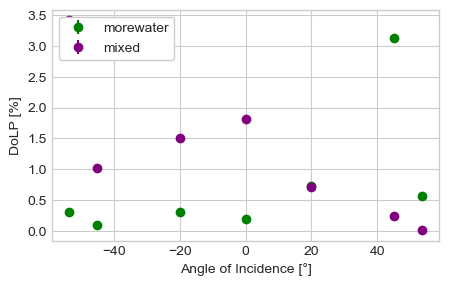

In [4304]:
fig, axs = plt.subplots(1,figsize = (5,3),sharex = True)

i = 70
j = 55
#plt.errorbar(angles,dolp_ice[:,0,i]*100,yerr=dolp_ice_std[:,i]*100,fmt='o',color='b',label='ice')
#plt.errorbar(angles,dolp_w[:,0,i]*100,yerr=dolp_w_std[:,i]*100,fmt='o',color='r',label='water')
#plt.errorbar(angles,dolp_cap[:,0,i]*100,yerr=dolp_icecap_std[:,i]*100,fmt='o',color='orange',label='ice cap')
plt.errorbar(angles,dolp_ice[:,1,i],yerr=dolp_ice_std[:,i],fmt='o',color='green',label='morewater')
plt.errorbar(angles,dolp_w[:,1,i],yerr=dolp_w_std[:,i],fmt='o',color='purple',label='mixed')
#plt.errorbar(angles,dolp_morew[:,0,j]*100,yerr=dolp_morew_std[:,j]*100,fmt='x',color='green')#,label='morewater')
#plt.errorbar(angles,dolp_m[:,0,j]*100,yerr=dolp_m_std[:,j]*100,fmt='x',color='purple')#,label='mixed')

#plt.errorbar(angles,dolp_w[:,0,22]*100,yerr=dolp_w_std[:,22]*100,fmt='x',color='b')
#plt.errorbar(angles,dolp_w[:,0,70]*100,yerr=dolp_w_std[:,70]*100,fmt='x',color='r')

legend =plt.legend(facecolor='white', framealpha=1, frameon=True,loc = "upper left")
legend.get_frame().set_facecolor('w')
plt.xlabel('Angle of Incidence [\N{DEGREE SIGN}]')
plt.ylabel('DoLP [%]')

<ErrorbarContainer object of 3 artists>

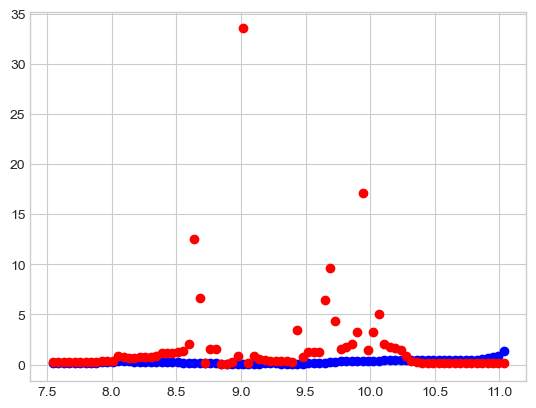

In [4306]:
i = 2
plt.errorbar(lambda_c[6:90],np.mean(dolp_wl[i,:,6:],axis=0),yerr=dolp_wl_std[i,6:],fmt='o',color='blue')
plt.errorbar(lambda_c[6:90],np.mean(dolp_w[i,:,6:],axis=0),yerr=dolp_w_std[i,6:],fmt='o',color='red')
